# **WSN Project** - Central Hidrelétrica Cachoeira Dourada S.A.

A wireless sensor network (WSN) is a collaborative network that contains a collection of sensor nodes, each of which has a power source, and is able to individually and autonomously complete the function of discovering and maintaining routing to other sensors through wireless links.

A WSN deployed in an industrial environment must assure an acceptable degree of reliability and security, thus, robust network design is required. Traditional methods, in which the propagation channel is evaluated through point-to-point communication links prior to the network installation, are frequently not executed in complex Electric Power System.<br>
Similar to other EPS environments, power plants are complex facilities that present strict regulations for safety, making the wireless channel analysis difficult with the conventional point-to-point methods. Therefore, it is often the case that the radio nodes of the WSN are initially located near the spots where specific equipment needs to be monitored, and then the number of routers and their hardware settings are adjusted following a trial-and-error procedure until a stable topology is achieved. This recurrent procedure may not yield an optimum result from the standpoint of the number of nodes, redundancy, power consumption, etc.<br>

- As an alternative to characterize the channel of communication the authors have propose that the use of the RSSI data registered by the WSN nodes can then be used as a characterization method, and consequently, as a tool for improving the settings of the installed network.
- Through the analysis RSSI data, long-term mean values are obtained and used as a basis for comparing the channel behavior to events related to operations on the power plant that occurred on particular days. Complementary to this, we discuss how the recorded data can reveal issues about the functioning of specific nodes.
- Through a cross-correlation analysis of the measured RSSI data of each bidirectional link, it is possible to estimate the rate of increase on the transmission power of each node, which is directly related to the quality of the links.
- High-level RSSI values registered during recordings, which are treated as undesired information when modeling the channel, can be co-related to the electromagnetic interference (EMI) sources present in the power plant. 

The data comes from the Hidroelectric Power Plant Cachoeira Dourada (MG, Brazil) The systems consist in 7 Routers and 1 Coordinator, total of 8 Routers. The location of the radios can be seen in the image.

1. **There are 8 locations and 1 Router for every location.**
2. **Each router gives information about it's tempreature and bus voltage using channels 7 and 6 respectively and a timestamp.**
3. **Only 3 of the radios were used to gather information from sensors, the others were used for network routing.<br>**
    In <span style="color:red">Montante UG5</span> location is Router <span style="color:blue">57.FE.0E</span>, wich communicates with Sensors: 
        Acquisition - Temperature E5.5A.24  that extract info from (2) PT100 using channels 0 and 1, and it's temperature and VBus using channel 7 and 6. 
        Acquisition - Current / Voltage CB.0A.C0 that extract info about the level in the dim using channel 1, and it's temperature and VBus using channel 7 and 6.
        Power - Solar Panel B2.9F.A9 that extract the MPPT voltage and the voltage from the solar panel using channels 0 and 1.
    
    In <span style="color:red">Poço de Drenagem A</span> location is Router <span style="color:blue">57.FE.0F</span>, wich communicates with: 
        Acquisition - Current / Voltage E9.39.32  which is a level probe , uses channel 1.
        Power - AC/DC Input 0D.82.38 that measures voltage from Battery and Supply voltage using channel 0 and 1, and it's temperature and VBus using channel 7 and 6.
    
    In <span style="color:red">Transformador Elevador</span> location is Router <span style="color:blue">57.FE.03</span>, wich communicates with: 
        Acquisition - Temperature sensor 8D.AC.91  which gives 2 temperatures (Oil and Gabinetes) through channels 0 and 1.
        Power - Solar Panel sensor 39.E2.80 that extract the MPPT voltage and the voltage from the solar panel using channels 0 and 1.
     
     
4. **The <span style="color:red">Montante UG5 and Transformador Elevador Routers</span> are powered by Solar energy.**

5. **The <span style="color:red">Poço de Drenagem A Router</span> is powered by AC energy from the Hydroelectric plant.**

6. **Radio RC is the Coordinator (00.57.FE.04). <br>
   Radio R1 is module 00.57.FE.09 <br>
   Radio R4 is module 00.57.FE.01 <br>
   Radio R5 is in Montante UG5 and module 00.57.FE.0E <br>
   Radio R2 is in Transformador Elevador and module 00.57.FE.03 <br>
   Radio R6 is in Poço de Drenagem A and module 00.57.FE.0F <br>
   Radio R3 is also in Poço de Drenagem A but is a Radio, module 00.57.FE.05 or 00.57.FE.06.**

The radios operated in the 2.4 GHz band under the Zigbee 3.0 protocol and in a mesh configuration. The theoretical receiver sensitivity of each node was −95 dBm. All the radios were set as
routers (relays), so each one was able to establish different routes to communicate up to the coordinator. The coordinator uploaded the radios data to a local database. 

The radios are able to automatically increase their transmission power to improve their link quality


<img src="..\\images\\Router_Location.jpg" style="width:600px;heigth:600px"/>

### **Necessary libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt
import matplotlib.dates as mdates
from time import time
import scipy.io

from sklearn import metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import pywt
from scipy.fftpack import fft
from collections import Counter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from scipy.signal import welch

# for anomalies
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers.recurrent import LSTM
from keras.models import model_from_json

from IPython.display import HTML

Using TensorFlow backend.


In [2]:
pd.options.mode.chained_assignment = None  # default='warn'
sns.set(style='whitegrid', palette='deep', font_scale=1.2)
# this is for setting the precision to 4, so the data is better distributed on screen
# and the maximum number of columns to display
pd.set_option('max_columns',40, 'precision',4)
keras.__version__

'2.3.1'

In [3]:
# defining some constants
Type=['Network Coordinator', 'Radio - 2.4 GHz','Acquisition - Temperature',
      'Acquisition - Current / Voltage', 'Power - Solar Panel', 'Power - AC/DC Input']

Modules={"00.57.FE.04":'Net-Coordinator',
         "00.57.FE.0E":'Radio-2.4 GHz',
         "00.57.FE.0F":'Radio-2.4 GHz',
         "00.57.FE.06":'Radio-2.4 GHz',
         "00.57.FE.09":'Radio-2.4 GHz',
         "00.57.FE.01":'Radio-2.4 GHz',
         "00.57.FE.05":'Radio-2.4 GHz',
         "00.57.FE.03":'Radio-2.4 GHz',
         "29.E5.5A.24":'Acq-Tempe',
         "A7.CB.0A.C0":'Acq-Current/Volt',
         "34.B2.9F.A9":'P-Solar Panel',
         "01.E9.39.32":'Acq-Current/Volt',
         "A4.0D.82.38":'P-AC/DC Input',
         "9F.8D.AC.91":'Acq-Tempe',
         "50.39.E2.80":'P-Solar Panel'}

column_names=['Timestamp','Module','Type','Temp_Mod', 'VBus',
              'PT100(0)', 'PT100(1)', 'LVL_Dim(1)', 'V_MPPT', 
              'V_Panel','LVL_Drain(1)','VBat', 'V_Supp','Temp_Oil',
              'Temp_gab','V_MPPT_TE','V_Panel_TE']

column_names_dates = ['Timestamp', 'Module', 'Type', 'month',
       'year', 'day', 'week', 'hour', 'Temp_Mod', 'VBus', 'PT100(0)',
       'PT100(1)', 'LVL_Dim(1)', 'V_MPPT', 'V_Panel', 'LVL_Drain(1)', 'VBat',
       'V_Supp', 'Temp_Oil', 'Temp_gab', 'V_MPPT_TE', 'V_Panel_TE']

columns_radio = ['Timestamp','Module','Type', 'Transmitter', 'N1', 'P_N1(dbm)',
                 'N2', 'P_N2(dbm)', 'N3', 'P_N3(dbm)',
                 'N4','P_N4(dbm)', 'N5', 'P_N5(dbm)',
                 'N6', 'P_N6(dbm)', 'N7','P_N7(dbm)']

columns_radio2 = ['Timestamp','Module','Type', 'Receiver', 'Tx1', 'P_Tx1(dbm)',
                 'Tx2', 'P_Tx2(dbm)', 'Tx3', 'P_Tx3(dbm)',
                 'Tx4','P_Tx4(dbm)', 'Tx5', 'P_Tx5(dbm)',
                 'Tx6', 'P_Tx6(dbm)', 'Tx7','P_Tx7(dbm)']

#### Some Helper functions for later

In [4]:
# Helper functions for later

def add_date_features(df):
    
    #df.reset_index(inplace=True)
    # take date features from timeseries
    df['hour'] = df['Timestamp'].dt.hour
    df['day'] = df['Timestamp'].dt.day
    df['month'] = df['Timestamp'].dt.month
    df['week'] = df['Timestamp'].dt.week
    df['weekday'] = df['Timestamp'].dt.weekday
    df['daylight'] = ((df['hour'] >= 7) & (df['hour'] <= 19)).astype(int)
    df.set_index('Timestamp', drop=True, inplace=True)
    return df

def drop_power(df, Powers):
    # for dropping the -9 dbm value
    # Powers is a dictionary with the names
    # of the columns
    for ii in Powers:
        indexx = df[df[ii] == -9].index
        df = df.drop(df.index[indexx], axis=0)
        df.reset_index(inplace=True, drop=True)
    return df

def create_RSSI_dataframe(df_powers, plot=True, start_date='2018-01-01', end_date='2018-02-16', raw=True, resample_time='60Min'):
    '''
    This functions returns the entire dataset with the RSSI
    aranged by receiver
    '''
    #RECEIVERS = np.array(df_powers['Receiver'].unique())
    dff = pd.DataFrame(data=None)
    for i in range(len(RECEIVERS)):
        subset, serie, transmitters, Tx = arange_RSSI_serie(df_powers, receiver=i, start_date=start_date, end_date=end_date, plot=False, plot_entire=False)
        serie['Receiver'] = RADIOS[i]
        dff = pd.concat([dff, serie])
    
    if plot==True:
        color=['b','r','m','g','c','orange', 'y', 'grey']
        fig, axes = plt.subplots(nrows=RECEIVERS.shape[0], ncols=1, figsize=(24,28), sharey=True, sharex=True)
        fig.suptitle('RSSI data from every receiver radio', x=0.5, y=1.02, fontsize=20)
        for ii, ax in zip(RADIOS, axes):
            if raw == True:
                dff[dff['Receiver']==ii].dropna(axis=1, how='all').plot(ax=ax)
            else:
                dff[dff['Receiver']==ii].dropna(axis=1, how='all').resample(resample_time).mean().plot(ax=ax)
            ax.tick_params(labelrotation=0)
            ax.set_yticks(np.arange(-10, -100, step=-10))
            ax.set_title('RSSI from {}'.format(ii))
            ax.legend(loc='upper right')
        plt.tight_layout()
    
    return dff

def arange_RSSI_serie(df_powers, receiver=0, start_date='2018-01-01', end_date='2018-02-16', sharex=False, sharey=True, figsize=(24,14), joint=True, plot=True, plot_entire=True):
    
    Receivers = np.array(df_powers['Receiver'].unique())
    subset = df_powers[df_powers['Receiver'] == Receivers[receiver]][start_date:end_date]
    subset = subset.dropna(axis=1, how='all')

    Tx, Ptx = [], []
    for i in range(int(subset.columns[3:].shape[0]/2)):
        Tx.append(subset.columns[3:][i*2])
        Ptx.append(subset.columns[4:][i*2])

    transmitters = []
    for ii in Tx:
        for i in range(len(subset[ii].value_counts().index)):
            transmitters.append(subset[ii].value_counts().index[i])
    transmitters = pd.Series(data=transmitters)
    transmitters.drop_duplicates(inplace=True)
    transmitters = transmitters.values
    #print(transmitters, Tx, Ptx)

    serie = pd.DataFrame(data=None, index=subset.index)
    for t in transmitters:
        dff = pd.DataFrame(data=None)
        for ii,jj in zip(Tx, Ptx):
            dff = pd.concat([dff, subset[subset[ii]==t][jj]])
        dff[t] = dff
        dff.drop(0, axis=1, inplace=True)
        serie[t] = dff[t][~dff[t].index.duplicated()]

    if plot==True:
        if plot_entire == True:
            plt.figure(figsize=(24,4))
            subset['P_Tx1(dbm)'].plot()
            plt.title('RSSI from Neighbour 1 over the entire period for Receiver {}'.format(subset['Receiver'].unique()[0]))
            plt.xticks(rotation=0);
            plt.tight_layout()   
        
        color=['b','r','m','g','c','black', 'y', 'grey']
        if joint==False:
            fig, axes = plt.subplots(nrows=transmitters.shape[0], ncols=1, figsize=figsize, sharex=sharex, sharey=sharey)
            plt.xticks(rotation=0)
            for ii, ax in zip(range(transmitters.shape[0]), axes.flat):
                serie[transmitters[ii]].plot(ax=ax, color=color[ii], label=('Transmitter '+transmitters[ii]))
                ax.tick_params(labelrotation=0)
                ax.legend()
            plt.tight_layout()
        else:
            fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(24,4), sharex=True, sharey=True)
            plt.xticks(rotation=0)
            plt.title('RSSI from Transmitters to Rec {}'.format(Receivers[receiver]))
            for ii in range(transmitters.shape[0]):
                serie[transmitters[ii]].plot(ax=axes, color=color[ii], label=('Transmitter '+transmitters[ii]))
                axes.tick_params(labelrotation=0)
                axes.legend(loc='upper right')
            plt.tight_layout()
               
    return subset, serie, transmitters, Tx

def plot_count_transmitters(dff, subset):
    plt.figure(figsize=(12,5))
    plt.title('Amounth of Data by Receiver')
    sns.countplot(x='Receiver', data=dff, palette='Set3')
    plt.tight_layout()

    Tx, Ptx = [], []
    for i in range(int(subset.columns[3:].shape[0]/2)):
        Tx.append(subset.columns[3:][i*2])
    
    fig, axx = plt.subplots(3,3, figsize=(30,14))
    fig.delaxes(axx[2,1])
    fig.delaxes(axx[2,2])
    plt.suptitle('Transmitters in every Neighbour sendind data to Receiver '+ subset['Receiver'].unique()[0], x=0.5, y=1.02, fontsize=20)
    if len(Tx) < 4: 
        fig.delaxes(axx[2,0]);fig.delaxes(axx[1,2])
        fig.delaxes(axx[1,1]);fig.delaxes(axx[1,0])
    if len(Tx) == 4:
        fig.delaxes(axx[2,0]);fig.delaxes(axx[1,2])
        fig.delaxes(axx[1,1])
    if len(Tx) == 5:
        fig.delaxes(axx[2,0]);fig.delaxes(axx[1,2])
    if len(Tx) == 6:
        fig.delaxes(axx[2,0])
    for ii,ax in zip(Tx, axx.flat):
        sns.countplot(x=ii, data=subset, ax=ax, palette='Set2')
    plt.tight_layout()

def plot_reciprocal_RSSI(dff):
    RECEIVERS = np.array(df_powers['Receiver'].unique())
    color=['darkblue','c','g','y','r','m','orange', 'b']
    fig, axes = plt.subplots(nrows=RECEIVERS.shape[0], ncols=1, figsize=(24,28), sharey=True, sharex=True)
    fig.suptitle('Reciprocal RSSI measurement of all Radios', x=0.5, y=1.02, fontsize=20)
    for ii, ax in zip(RECEIVERS, axes):
        recipr = dff[['Receiver', ii]]
        rec = []
        for jj, c in zip(RADIOS, color):
            if recipr[recipr['Receiver']== jj].dropna(axis=1, how='all').columns.shape[0] != 1:
                recipr[recipr['Receiver']== jj].plot(ax=ax, color=c)
                ax.tick_params(labelrotation=0)
                ax.set_title('RSSI from Transmitter{}'.format(ii))
                rec.append(jj)
        ax.legend(labels=rec, loc='upper right')
        plt.tight_layout()

def dist_transmissions(df, receiver, Receivers, ax, start_date ='2018-01-01', end_date='2018-01-10'):

    subset, serie, transmitters, Tx = arange_RSSI_serie(df, receiver, joint=True, plot=False)
    for i in serie.columns:
        sns.distplot(serie[i].dropna(), kde=False, label=i, bins=20, axlabel='Receiver '+ Receivers[receiver], ax=ax)
        ax.legend()
        ax.set_xticks(np.arange(-10, -100, step=-10))
    plt.tight_layout()

def boxplot_PowerMod_date(dff, Tx='0x0057FE05', palette='Set3', date_arr=['day','weekday','week','hour'], sharey=True):
    fig, axarr = plt.subplots(nrows=1, ncols=4, figsize=(24,4), sharey=sharey)
    fig.suptitle('Transmitter '+Tx+' over different date frames',y=1.03, fontsize=15)
    #sns.boxplot(x='month',y=Neigh, data=df, ax=axarr[0], palette='Set3')
    sns.boxplot(x=date_arr[0], y=Tx, data=dff, ax=axarr[0], palette='Set3')
    sns.boxplot(x=date_arr[1], y=Tx, data=dff, ax=axarr[1], palette='Set3')
    sns.boxplot(x=date_arr[2], y=Tx, data=dff, ax=axarr[2], palette='Set3')
    sns.boxplot(x=date_arr[3], y=Tx, data=dff, ax=axarr[3], palette='Set3')

def plot_by_date(dff, by='hour', nrows=2, ncols=4, figsize=(24,7)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=False, sharey=True)
    fig.suptitle('Mean Values by '+ by, x=0.5, y=1.02, fontsize=18)
    for i,ax in zip(dff.columns[1:9], axes.flat):
        ax.set_title('{} by {}'.format(i, by))
        data=dff.groupby(by).mean()[[i]]
        sns.lineplot(data=data, markers=True,ax=ax, err_style='bars')
        #ax.set_xticks(np.arange(0,24,2))
    plt.tight_layout()
    
def append_temperatures_toRSSI(df, df_powers, Modules, start_date, end_date, resample_time='30S'):
    '''
    append the temperatures of the receiver radio 
    and the temperature from transmitters
    '''
    subset, serie, transmitters, Tx = arange_RSSI_serie(df_powers, receiver=0,start_date=start_date, end_date=end_date, joint=True, plot=False)
 
    # get receiver name
    for i in Modules:
        if i[-2:] == subset.Receiver.unique()[0][-2:]:
            receiver = i

    # get Receiver temperature over entire period
    serie = serie.resample(resample_time).mean()
    resampled_df = df[df['Module']== receiver]['2018-01-01':'2018-01-18'].resample(resample_time).mean()[['Temp_Mod', 'VBus']]
    resampled_df = resampled_df.fillna(resampled_df.bfill())
    serie['Receiver'] = receiver
    serie[['Temp_Rece', 'VBus_Rec']] = resampled_df 

    # need to do this because of the difference in the names
    mod = []
    for ii in serie.columns:    
        last=ii[-2:]
        for i in Modules:
            if i[-2:] == last:
                mod.append(i)

    # transmitters temperatures
    for tx in mod:
        resampled_df = df[df['Module']== tx]['2018-01-01':'2018-01-18'].resample(resample_time).mean()[['Temp_Mod']]
        resampled_df = resampled_df.fillna(resampled_df.bfill())
        serie[['Temp_' + tx]] = resampled_df 
    
    return serie

def get_outliers(df, Modules, k_factor=1.5, std_times=3, verbose=True, remove=True, method='z_score'):
    
    '''
    This function identifies outliers in a Dataset.
    Two methods can be used, z_score and interquartile.
    If the data follos a Gaussian like distribution Z_score 
    can be used, if not is better to use the interquartile method. 
    This are not very good estimation since some of this outliers can be
    noveltys (correct data that explains something that happens
    or viceversa)
    k_factor: factor for interquartile method
    std_times: how many standard deviations away from the mean
               for Z_Score method
    df: Original Dataframe
    remove: If False don't remove the outliers
    Modules: Dictionary type
    '''
    
    # Dataframe to save Outliers by Modules
    df_outliers = pd.DataFrame(data=None)
    
    for module in Modules:
        # Take a slice of the dataset by module
        slice_of_data = df[df['Module']== module]
        # Drop Useless Columns (columns with all nan values)
        slice_of_data = slice_of_data.dropna(axis=1, how='all')
        if method == 'z_score':
            # calculate summary statistics
            mean, std = slice_of_data['Temp_Mod'].mean().round(4), slice_of_data['Temp_Mod'].std().round(4)
            # identify outliers outside 3 standar deviations
            cut_off = std * std_times
            lower, upper = mean - cut_off, mean + cut_off
            # identify outliers
            outliers = [x for x in slice_of_data['Temp_Mod'] if x < lower or x > upper]
            # save outliers in dataframe
            df_outliers = pd.concat([df_outliers, pd.Series(outliers, name=module, dtype=float)], axis=1)
            #print(Counter(outliers))
            outliers_removed = [x for x in slice_of_data['Temp_Mod'] if x > lower and x < upper]
            
            if verbose == True:    
                print('Outliers indentified: {} in module {}'.format(len(outliers), module))
                print('Non-outlier observations: {} in module {}'.format(len(outliers_removed), module))
        
        if method == 'interquartile':
            q25, q75 = np.percentile(slice_of_data['Temp_Mod'], 25), np.percentile(slice_of_data['Temp_Mod'], 75)
            IQR = q75 - q25
            cut_off = IQR * k_factor
            lower, upper = q25 - cut_off, q75 + cut_off
            outliers = [x for x in slice_of_data['Temp_Mod'] if x < lower or x > upper]
            outliers_removed = [x for x in slice_of_data['Temp_Mod'] if x >= lower and x <= upper]
            # save outliers in dataframe
            df_outliers = pd.concat([df_outliers, pd.Series(outliers, name=module, dtype=float)], axis=1)
            
            if verbose == True:    
                print('Percentiles 25th = {} 75th = {} IQR = {}'.format(q25, q75, IQR.round(3)))
                print('Outliers indentified {}'.format(len(outliers)))
                print('Non-outlier observations: %d' % len(outliers_removed))
            
    
        # Remove the Outliers
        if remove == True:    
            for ii in np.unique(outliers):
                if verbose == True:
                    print('Removing {} from Module {}'.format(ii, module))
                else:
                    slice_of_data = df[df['Module']== module]
                    indexx = slice_of_data[slice_of_data['Temp_Mod'] == ii].index
                    df = df.drop(df.index[indexx], axis=0)
                    df.reset_index(inplace=True, drop=True)
    
    return df_outliers, df 

def create_train_test(slice_of_data, resample_time='5Min', feature_index=0, feature_name='Temp_Mod', scaler=StandardScaler(),
                      final_date='2019-01-20 00:00:05', split_date = '2019-01-01 00:00:05', test_date = '2019-01-17 00:00:05',
                      figsize=(20,4)):
    '''
    The passed dataset must have a timestamp as index.
    Resamples the dataset into a given freq (default 5 min) using
    rolling mean and split it into training and testing dataframes. 
    Scales the data using Sklearn Standard Scaler and returns the 
    numpy arrays of the x_train, y_train, x_test, y_test.
    
    slice_of_data: data to be splitted
    feature_index: index of the feature to be predicted (for y_train and test)
    feature_name: name of the feature in dataset
    final_date: date limit to split
    split_date: date to start splitting
    test_date: starting test date
    
    data: dataframe with all the resampled data, combines train and test
    '''
    
    # Resample to 5 min with rolling mean
    slice_of_data = slice_of_data.resample(resample_time).mean()
    # Method Backward Fill
    slice_of_data = slice_of_data.fillna(slice_of_data.bfill())
    
    data = slice_of_data.loc[split_date:final_date]
    train_data = slice_of_data.loc[split_date:test_date] 
    test_data = slice_of_data.loc[test_date:final_date]
    
    #Scale the data to unit variance. We only fit in the Training data
    #scaler = StandardScaler()
    # Scale the data and convert it into dataframe for easy splitting
    X_train = pd.DataFrame(scaler.fit_transform(train_data), columns=[slice_of_data.columns]).to_numpy()
    X_test = pd.DataFrame(scaler.transform(test_data), columns=[slice_of_data.columns]).to_numpy()
    
    # Since i'm going to predict only temperature
    y_train, y_test = X_train[:,feature_index], X_test[:,feature_index]
    
    slice_of_data.loc[split_date:test_date][feature_name].plot(figsize=figsize, label='Train')
    slice_of_data.loc[test_date:final_date][feature_name].plot(figsize=figsize, title=('Resampled Data to {} per data (Rolling mean)'.format(resample_time)), color='r', label='Test')
    plt.legend(); plt.tight_layout()
    
    return data, train_data, test_data, X_train, X_test, y_train, y_test, scaler

def separete_modules(df, dictionary):
    '''
    Create a list of dataframes with different modules
    '''
    slices = []
    for module in dictionary:
        # Take a slice of the dataset by module
        # Drop Useless Columns (columns with all nan values)
        slice_of_data = df[df['Module']== module].dropna(axis=1, how='all')
        slice_of_data.reset_index(inplace=True, drop=True)
        slices.append(slice_of_data)
    return np.asarray(slices)

def serialize_model(model, history, name='model'):
    '''
    Save model and history
    '''
    # serialize model to JSON
    model_json = model.to_json()
    with open(name+'.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(name+'.h5')
    history.to_csv(name+'.csv')
    print("Saved model to disk")
    
def load_model(name='model'):
    json_file = open(name+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(name+'.h5')
    print("Loaded model from disk")
    return loaded_model

def split_sequences(X_train, feature_index=0, n_steps=32):
    
    '''
    Split a multivariate sequence into samples for single feature prediction
    Taken and adapted from Machinelearningmastery.
    Split the training set into segments of a specified timestep
    and creates the labels.
    '''
    n_steps = n_steps+1
    # Place the column of the feature to predict at the end of the dataset
    sequences = np.concatenate([X_train, X_train[:,feature_index].reshape(-1,1)],axis=1)
    
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix-1, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    
    print(np.shape(X),np.shape(y))
    return np.array(X), np.array(y)

def split_sequences_multivariate(sequences, n_steps=32):
    
    '''
    Split a multivariate sequence into samples for single feature prediction
    Taken and adapted from Machinelearningmastery.
    Split the training set into segments of a specified timestep
    and creates the labels.
    '''
    #n_steps = n_steps+1
    # Place the column of the feature to predict at the end of the dataset
    #sequences = np.concatenate([X_train, X_train[:,0].reshape(-1,1)],axis=1)
    
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    
    print(np.shape(X),np.shape(y))
    return np.array(X), np.array(y)

def get_abs_err(X, y, model, std=3, plot=True, n_outputs=6):
    '''
    get the absolute error between prediction and labels
    and the threshold. Plots the error distribution also.
    '''
    x_pred = model.predict(X)
    
    if np.shape(y)[-1] == n_outputs:
        abs_err = np.asarray(abs(x_pred - y))
        threshold = abs_err[0,:].std()*std
        if plot==True:
            fig, (ax1) = plt.subplots(1, 1, figsize=(10,4))
            sns.distplot(abs_err[0,:], ax=ax1, label='Error distribution')
            plt.axvline(x=threshold, ymin=0, ymax=8, color='r', label='Threshold')
            plt.title('Error distribution, threshold set in {}'. format(threshold.round(4)))
            #plt.xticks(np.arange(0,1.1,0.1))
            plt.legend(); plt.tight_layout()
            return pd.DataFrame(abs_err), threshold
        else:
            return pd.DataFrame(abs_err)
    else:
        abs_err = np.asarray(abs(x_pred - y.reshape(-1,1)))
        threshold = abs_err.std()*std
        if plot==True:
            fig, (ax1) = plt.subplots(1, 1, figsize=(10,4))
            sns.distplot(abs_err, ax=ax1, label='Error distribution')
            plt.axvline(x=threshold, ymin=0, ymax=8, color='r', label='Threshold')
            plt.title('Error distribution, threshold set in {}'. format(threshold.round(4)))
            #plt.xticks(np.arange(0,1.1,0.1))
            plt.legend(); plt.tight_layout()
            return pd.Series(abs_err.reshape(-1)), threshold
        else:
            return pd.Series(abs_err.reshape(-1))

def create_segments(data, length=50):
    '''
    create sequence previous data points for each data points 
    in this case y is one dimensional because my output is going to be one value alone
    '''
    result = []
    for index in range(len(data) - length):
        result.append(data[index: index + length])
    return np.asarray(result)

def plot_model_results(model, history_df, X, y, index, feature_index=0):
    '''
    Plot the scores of the model and the prediction vs the
    real time series
    '''
    prediction = model.predict(X)
    if prediction.shape[-1] == 1:
        pred_df = pd.DataFrame(data= np.concatenate((model.predict(X), y.reshape(-1,1)), axis=1), columns=['Prediction', 'True'], index=index)
    else:
        pred_df = pd.DataFrame(data= np.concatenate((model.predict(X)[:,feature_index].reshape(-1,1), y[:,feature_index].reshape(-1,1)), axis=1), columns=['Prediction', 'True'], index=index)
    
    fig = plt.figure(figsize=(24,5))
    spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 3])
    ax0 = fig.add_subplot(spec[0])
    sns.lineplot(data=history_df[['loss','val_loss']], markers=True)
    # plot the prediction and the reality (for the test data)
    ax1 = fig.add_subplot(spec[1])
    pred_df.plot(ax=ax1)
    plt.legend(loc='upper left')
    plt.title('Prediction and Truth (Scaled)')    
    plt.tight_layout()
    
def detect_anomaly(data, threshold, error, train_shape):
    
    df = data
    df.reset_index(inplace=True)
    # data with anomaly label (test data part)
    test = (error >= threshold).astype(int)
    complement = pd.Series(0, index=np.arange(train_shape))
    
    # add the data to the main
    df['anomaly_LSTM'] = complement.append(test, ignore_index='True')
    df.set_index('Timestamp',inplace=True)
    #print(df['anomaly_LSTM'].value_counts())
    anomaly = df.loc[data['anomaly_LSTM'] == 1, ['Temp_Mod']] #anomaly
    return df, anomaly

def get_anomaly_and_pred(model, X, y, threshold, test_data, n_features=6, feature=0):
    
    index=test_data.index[64:]
    if np.shape(y)[-1] == n_features: 
        predictions = np.concatenate((model.predict(X)[:,feature].reshape(-1,1), y[:,feature].reshape(-1,1)), axis=1)
    else:
        predictions = np.concatenate((model.predict(X), y.reshape(-1,1)), axis=1)
        
    predictions_df = pd.DataFrame(data=predictions, columns=['Pred','True'], index=index)
    predictions_df['error'] = abs(predictions_df['True'] - predictions_df['Pred'])

    dates_index = predictions_df['error'].loc[predictions_df.error >= threshold].index

    anomaly = pd.Series(data=np.zeros(shape=(test_data.shape[0])), index=test_data.index, name='anomalies')
    anomaly.loc[dates_index] = predictions_df['error'].loc[predictions_df.error >= threshold].values.astype(bool)    
    #print('Anomalies founded {}'.format(anomaly.value_counts()[1]))
    
    return predictions_df, anomaly

def plot_anomalies_model(data, test_date, anomalies, select='LSTM',anomalies_svm=None, anomalies_forest=None):
    
    # data and anomaly are dataframes
    fig = plt.figure(figsize=(24,4))
    spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 3])

    if select=='LSTM':
        ax0 = fig.add_subplot(spec[0])
        sns.distplot(a=data[test_date:]['Temp_Mod'], kde=False, ax=ax0, label='Data')
        sns.distplot(a=data[data['anomaly_LSTM']==1]['Temp_Mod'], kde=False, color='darkred', ax=ax0, label='LSTM')
        ax0.legend()

        ax1 = fig.add_subplot(spec[1])
        sns.lineplot(data[test_date:].index, data[test_date:]['Temp_Mod'], label='Data', ax=ax1)
        ax1.scatter(data[data['anomaly_LSTM']==1].index, data[data['anomaly_LSTM']==1]['Temp_Mod'], color='red', s=30, label='LSTM anomalies')
        ax1.set_title('Anomalies detected in the last days')
        ax1.legend()
        
    if select == 'all':
        ax0 = fig.add_subplot(spec[0])
        sns.distplot(a=data[test_date:]['Temp_Mod'], kde=False, ax=ax0, label='Data')
        sns.distplot(a=data[data['anomaly_LSTM']==1]['Temp_Mod'], kde=False, color='darkred', ax=ax0, label='LSTM')
        sns.distplot(a=anomalies_svm[test_date:]['Temp_Mod'], kde=False, color='orange', ax=ax0, label='SVM')
        sns.distplot(a=anomalies_forest[test_date:]['Temp_Mod'], kde=False, color='green', ax=ax0, label='Isolation Forest')
        ax0.legend()

        ax1 = fig.add_subplot(spec[1])
        sns.lineplot(data[test_date:].index, data[test_date:]['Temp_Mod'], ax=ax1, label='Data')
        ax1.scatter(anomalies[anomalies==1].index, data[data['anomaly_LSTM']==1]['Temp_Mod'], color='red', s=30, label='LSTM anomalies')
        ax1.scatter(anomalies_svm[test_date:].index, anomalies_svm[test_date:]['Temp_Mod'], color='black', s=40, label='SVM', marker='x')
        ax1.scatter(anomalies_forest[test_date:].index, anomalies_forest[test_date:]['Temp_Mod'], color='orange', s=40, label='Isolation Forest')
        ax1.set_title('Anomalies detected in the last days')
        ax1.legend()
        
    if select=='others':
        ax0 = fig.add_subplot(spec[0])
        sns.distplot(a=data['Temp_Mod'], kde=False, ax=ax0)
        sns.distplot(a=anomalies['Temp_Mod'], kde=False, color='darkred', ax=ax0)
        ax1 = fig.add_subplot(spec[1])
        sns.lineplot(data.index, data['Temp_Mod'], ax=ax1)
        ax1.scatter(anomalies.index, anomalies['Temp_Mod'], color='red', s=20)
    
    plt.tight_layout()
    
def isolation_forest(data, n_estimators=50, outliers_fraction=0.01, scaler=StandardScaler()):
    
    df = data.copy()
    index = data.index
    df.reset_index(inplace=True, drop=True)

    #scaler = StandardScaler() #Scale the data to unit variance. We only fit in the Training data
    train = pd.DataFrame(scaler.fit_transform(df), columns=[df.columns]) # Scale the data and convert it into dataframe for easy splitting
    
    # train isolation forest 
    model =  IsolationForest(contamination=outliers_fraction, n_estimators=50, max_samples='auto', max_features=1.0)
    model.fit(train)
    
    # add the data to the main
    df['scores_isolation_f'] = pd.Series(model.decision_function(train))
    df['anomaly_IsolationF'] = pd.Series(model.predict(train))
    df['anomaly_IsolationF'] = df['anomaly_IsolationF'].map( {1: 0, -1: 1} )
    #print(df['anomaly_IsolationF'].value_counts())
    
    df = df.set_index(index, drop=True)
    # anomalies marked as 1
    anomaly_Iforest = df.loc[df['anomaly_IsolationF'] == 1, ['Temp_Mod']] #anomaly
    
    return df, anomaly_Iforest

def oneClass_SVM(data, nu=0.95, outliers_fraction=0.01, scaler=StandardScaler()):
    
    df = data.copy()
    index = data.index
    df.reset_index(inplace=True, drop=True)

    #scaler = StandardScaler() #Scale the data to unit variance. We only fit in the Training data
    train = pd.DataFrame(scaler.fit_transform(df), columns=[df.columns]) # Scale the data and convert it into dataframe for easy splitting
    
    # train isolation forest 
    model =  OneClassSVM(nu=nu * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
    model.fit(train)
    
    # add the data to the main  
    df['anomaly_SVM'] = pd.Series(model.predict(train))
    df['anomaly_SVM'] = df['anomaly_SVM'].map( {1: 0, -1: 1} )
    
    df = df.set_index(index, drop=True)
    # anomalies marked as 1
    anomaly_svm = df.loc[df['anomaly_SVM'] == 1, ['Temp_Mod']] #anomaly
    
    return df, anomaly_svm

def forecast_LSTM(model, X_train, X_test, n_timesteps, n_features):
    test_predictions = []
    first_eval_batch = X_train[-n_timesteps:]
    current_batch = first_eval_batch.reshape((1, n_timesteps, n_features))

    for i in range(len(X_test)):

        # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
        current_pred = model.predict(current_batch)[0]

        # store prediction
        test_predictions.append(current_pred) 

        # update batch to now include prediction and drop first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
        
    return test_predictions

## Loading the data and adding extra features

In [7]:
# Loading the data
df = pd.read_csv('../../Features.csv', usecols=column_names, parse_dates=['Timestamp'], infer_datetime_format=True)
df = add_date_features(df)
df.head()

Timestamp       Module             Type  Temp_Mod   VBus  \
0 2017-10-01 00:00:05  00.57.FE.04  Net-Coordinator      25.3  4.736   
1 2017-10-01 00:00:42  00.57.FE.04  Net-Coordinator      25.3  4.743   
2 2017-10-01 00:01:13  00.57.FE.04  Net-Coordinator      25.3  4.743   
3 2017-10-01 00:01:42  00.57.FE.04  Net-Coordinator      25.3  4.743   
4 2017-10-01 00:02:05  00.57.FE.04  Net-Coordinator      25.3  4.743   

   PT100(0)  PT100(1)  LVL_Dim(1)  V_MPPT  V_Panel  LVL_Drain(1)  VBat  \
0       NaN       NaN         NaN     NaN      NaN           NaN   NaN   
1       NaN       NaN         NaN     NaN      NaN           NaN   NaN   
2       NaN       NaN         NaN     NaN      NaN           NaN   NaN   
3       NaN       NaN         NaN     NaN      NaN           NaN   NaN   
4       NaN       NaN         NaN     NaN      NaN           NaN   NaN   

   V_Supp  Temp_Oil  Temp_gab  V_MPPT_TE  V_Panel_TE  
0     NaN       NaN       NaN        NaN         NaN  
1     NaN       NaN       NaN        NaN         NaN  
2     NaN       NaN       NaN        NaN         NaN  
3     NaN       NaN       NaN        NaN         NaN  
4     NaN       NaN       NaN        NaN         NaN

#### Show some basic information, like the amounth of null data

In [291]:
print(df.info())
print('\nNull Values {}'.format(df.isnull().sum()))
print('\nNaN Values {}'.format(df.isna().sum()))
#df_temperatures.where(df_temperatures== np.NaN).sum()
#df_temperatures.where(df_temperatures== 30).sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7847000 entries, 0 to 7846999
Data columns (total 21 columns):
 #   Column        Dtype         
---  ------        -----         
 0   Timestamp     datetime64[ns]
 1   Module        object        
 2   Type          object        
 3   Temp_Mod      float64       
 4   VBus          float64       
 5   PT100(0)      float64       
 6   PT100(1)      float64       
 7   LVL_Dim(1)    float64       
 8   V_MPPT        float64       
 9   V_Panel       float64       
 10  LVL_Drain(1)  float64       
 11  VBat          float64       
 12  V_Supp        float64       
 13  Temp_Oil      float64       
 14  Temp_gab      float64       
 15  V_MPPT_TE     float64       
 16  V_Panel_TE    float64       
 17  hour          int64         
 18  day           int64         
 19  month         int64         
 20  daylight      int32         
dtypes: datetime64[ns](1), float64(14), int32(1), int64(3), object(2)
memory usage: 1.2+ GB
None

Null Va

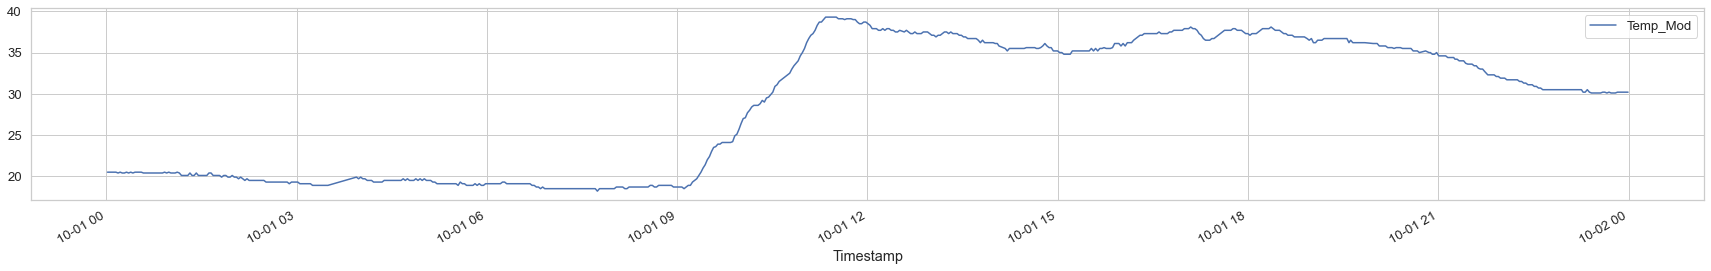

In [294]:
# Take a look to the sample 6000 to 6600 of temperatures
df.loc[5100:5800].plot(x='Timestamp', y = 'Temp_Mod', figsize=(24,4))
plt.tight_layout()

##### Let's describe the dataset. This shows intersting information like means, max and min values

We can see a description of the modules tempratures. Characteristics like max, min, mean values, standard deviation, lower percentile (25%), higher percentile (75%) and median value.

In [295]:
df.groupby('Module').describe()

Temp_Mod                                                 \
                 count     mean     std   min   25%   50%   75%   max   
Module                                                                  
00.57.FE.01   440658.0  30.4625  8.9760   5.6  24.1  27.6  36.1  61.8   
00.57.FE.03   486828.0  32.8362  7.3269   8.1  27.1  31.3  38.7  55.2   
00.57.FE.04  2516426.0  26.7424  2.3228  23.6  25.7  26.4  27.0  43.5   
00.57.FE.05   584781.0  34.4410  2.2282  25.7  33.0  34.6  36.1  46.8   
00.57.FE.06   626840.0  34.7139  2.2046  24.7  33.4  35.2  36.2  39.6   
00.57.FE.09   323537.0  29.8001  6.3345  11.0  25.3  28.8  34.4  49.7   
00.57.FE.0E   514892.0  27.9529  7.0415   6.1  23.5  26.4  32.3  58.3   
00.57.FE.0F   622643.0  31.6147  1.9436  23.5  30.2  32.1  33.0  36.7   
01.E9.39.32   287468.0  29.3734  1.8956  22.2  28.2  29.8  30.8  34.0   
29.E5.5A.24   323891.0  26.7427  6.0763   5.6  22.6  25.5  31.6  45.3   
34.B2.9F.A9   167044.0  28.2278  6.5829   6.6  23.5  26.6  33.7  48.2   
50.39.E2.80   179294.0  28.2632  7.3538   4.8  22.7  26.5  34.0  51.8   
9F.8D.AC.91   305505.0  27.8559  7.6319   1.0  22.1  26.4  34.3  47.6   
A4.0D.82.38   228384.0  30.9525  1.8632  23.7  29.7  31.3  32.3  35.6   
A7.CB.0A.C0   238809.0  27.4256  6.0334   6.3  23.2  26.2  32.3  44.2   

                  VBus                                                     \
                 count    mean     std    min    25%    50%    75%    max   
Module                                                                      
00.57.FE.01   440658.0  4.9576  0.0198  4.448  4.952  4.963  4.968  5.024   
00.57.FE.03   486828.0  3.2000  0.1674  1.376  3.179  3.207  3.228  3.563   
00.57.FE.04  2516426.0  4.7362  0.0078  4.568  4.736  4.736  4.743  4.776   
00.57.FE.05   584781.0  5.2683  0.0128  4.935  5.263  5.268  5.272  5.301   
00.57.FE.06   626840.0  4.9845  0.0028  4.851  4.984  4.984  4.984  5.008   
00.57.FE.09   323537.0  4.9995  0.0052  4.856  4.996  5.003  5.003  5.080   
00.57.FE.0E   514892.0  3.3379  0.1023  2.596  3.264  3.275  3.456  3.591   
00.57.FE.0F   622643.0  4.2727  0.0121  3.755  4.263  4.268  4.280  4.331   
01.E9.39.32   287468.0  4.3188  0.0033  4.245  4.318  4.319  4.320  4.326   
29.E5.5A.24   323891.0  3.3187  0.1227  3.085  3.235  3.241  3.440  3.544   
34.B2.9F.A9   167044.0  3.3587  0.1176  3.223  3.278  3.283  3.475  3.560   
50.39.E2.80   179294.0  3.3089  0.1549  2.186  3.294  3.301  3.326  3.606   
9F.8D.AC.91   305505.0  3.2317  0.1604  2.069  3.211  3.222  3.250  3.561   
A4.0D.82.38   228384.0  4.3050  0.0024  4.294  4.302  4.307  4.307  4.313   
A7.CB.0A.C0   238809.0  3.3335  0.1230  3.170  3.250  3.258  3.444  3.557   

             PT100(0)                        ...  day                    \
                count     mean     std  min  ...  25%   50%   75%   max   
Module                                       ...                          
00.57.FE.01       0.0      NaN     NaN  NaN  ...  8.0  15.0  23.0  31.0   
00.57.FE.03       0.0      NaN     NaN  NaN  ...  8.0  16.0  23.0  31.0   
00.57.FE.04       0.0      NaN     NaN  NaN  ...  8.0  16.0  23.0  31.0   
00.57.FE.05       0.0      NaN     NaN  NaN  ...  8.0  16.0  23.0  31.0   
00.57.FE.06       0.0      NaN     NaN  NaN  ...  8.0  16.0  23.0  31.0   
00.57.FE.09       0.0      NaN     NaN  NaN  ...  8.0  15.0  23.0  31.0   
00.57.FE.0E       0.0      NaN     NaN  NaN  ...  8.0  15.0  23.0  31.0   
00.57.FE.0F       0.0      NaN     NaN  NaN  ...  8.0  16.0  23.0  31.0   
01.E9.39.32       0.0      NaN     NaN  NaN  ...  8.0  16.0  23.0  31.0   
29.E5.5A.24  323891.0  27.1952  6.1642  5.8  ...  8.0  15.0  23.0  31.0   
34.B2.9F.A9       0.0      NaN     NaN  NaN  ...  8.0  15.0  23.0  31.0   
50.39.E2.80       0.0      NaN     NaN  NaN  ...  8.0  16.0  23.0  31.0   
9F.8D.AC.91       0.0      NaN     NaN  NaN  ...  8.0  16.0  23.0  31.0   
A4.0D.82.38       0.0      NaN     NaN  NaN  ...  8.0  16.0  23.0  31.0   
A7.CB.0A.C0       0.0      NaN     Na

## **Exploratory data analysis**

In the next graphic is shown the counting of the data by module. It can be seen that most data is comming from module 00.57.FE.04, which is the net coordinator. This is usefull information for the time of training any algorithm since the data from different sources or *labels* will have to be distributed 

In this boxplot can be seen the median values of temperatures and the percentiles. There are some outlayers for every module that, depending on their location, can be explained, and others that can be interpreted as corrupted data or miss readings. For example, module 00.57.FE.01 has some points that reach more than 60 degrees, in this case this module is a radio located in the UG3, so maybe this are corrupted data, but we can check this later with an outlier analysis.

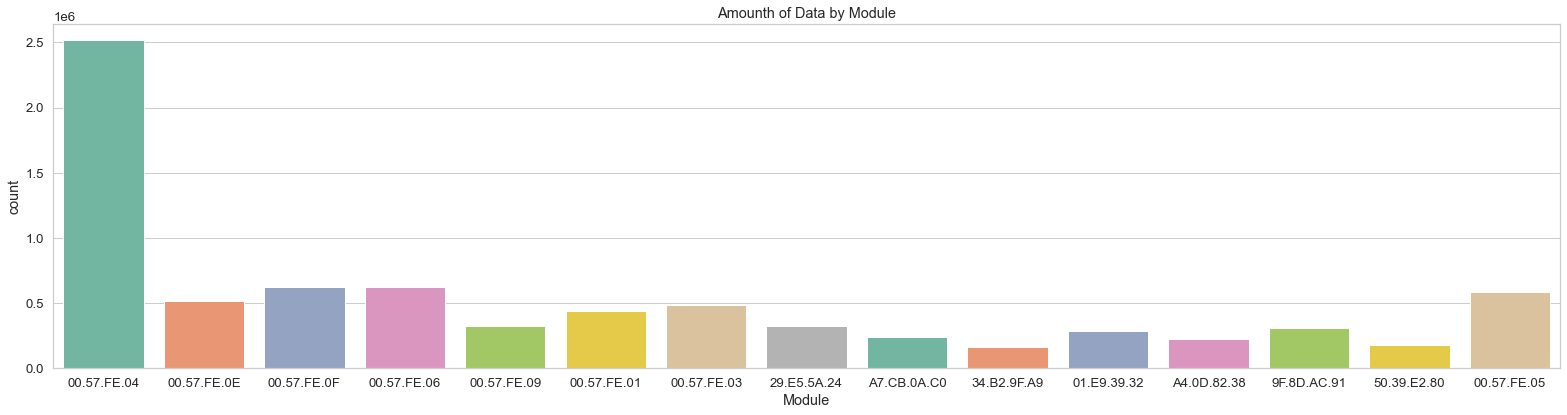

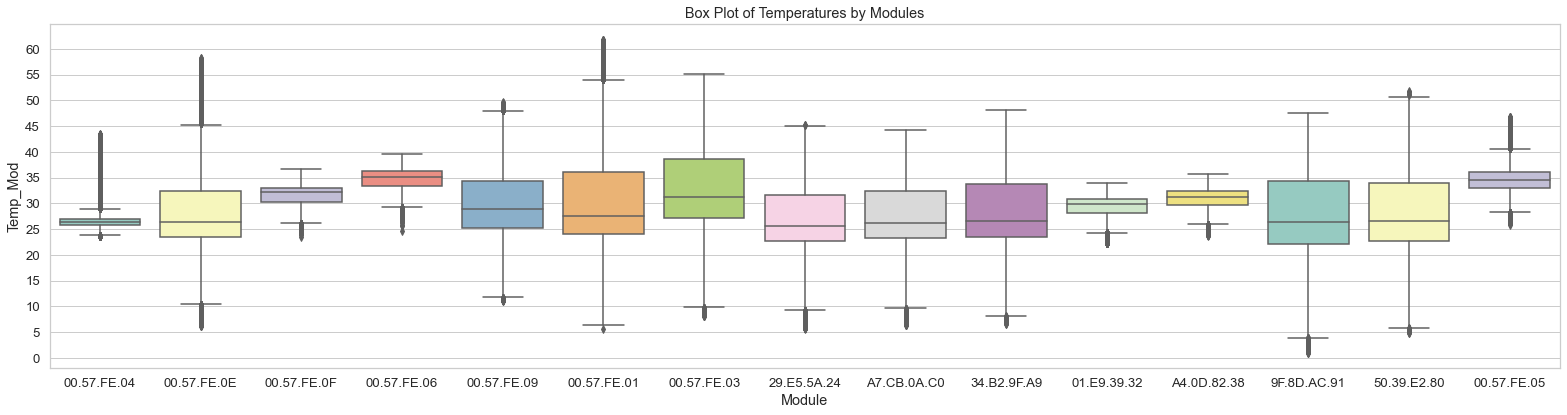

In [387]:
plt.figure(figsize=(22,6))
plt.title('Amounth of Data by Module')
sns.countplot(x='Module', data=df, palette='Set2')
plt.tight_layout()

plt.figure(figsize=(22,6))
plt.title('Box Plot of Temperatures by Modules')
sns.boxplot(x='Module',y='Temp_Mod',data=df, palette='Set3')
plt.yticks(ticks=np.arange(0,65,step=5))
plt.tight_layout()

#### Exploring the distribution of temperatures over the different Modules

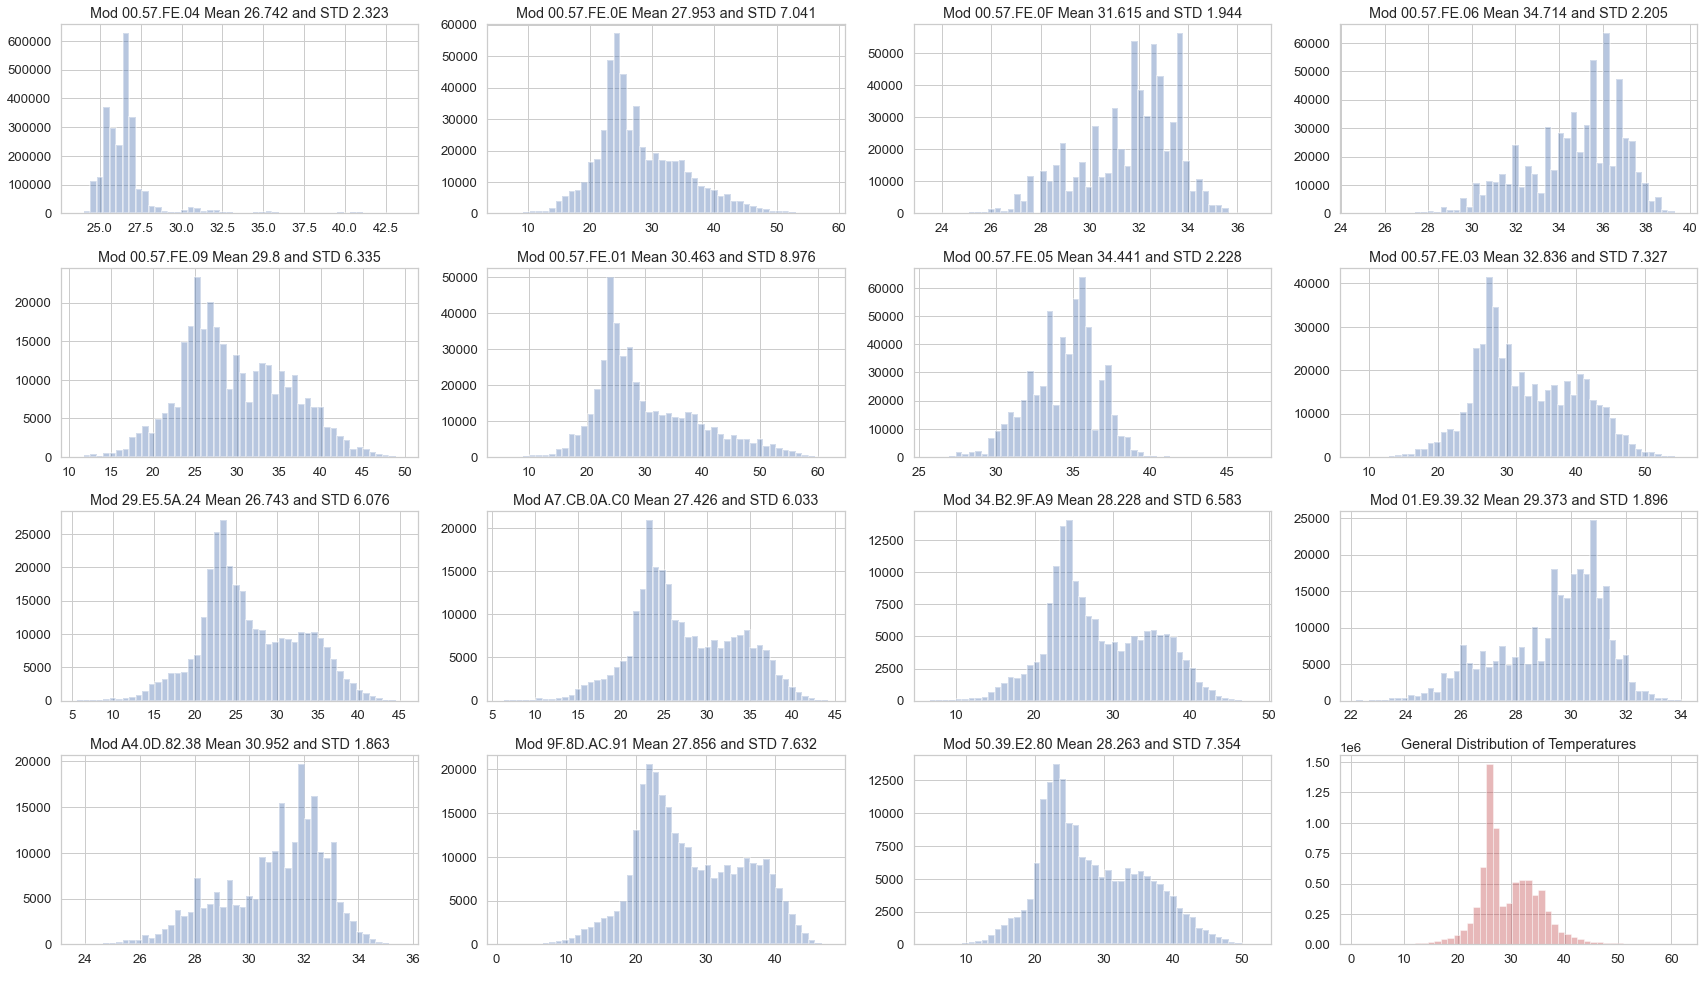

In [394]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(24,14), sharex=False)
#fig.delaxes(axes[3,3])
for i, ax in zip(Modules, axes.flat):
    sns.distplot(df[df['Module'] == i]['Temp_Mod'], kde=False, ax=ax, color='b', hist_kws={"linewidth":2})
    ax.set_title('Mod {} Mean {} and STD {}'.format(i, df[df['Module'] == i]['Temp_Mod'].mean().round(3), df[df['Module'] == i]['Temp_Mod'].std().round(3)))
    ax.set_xlabel('')
plt.title('General Distribution of Temperatures')
sns.distplot(a = df['Temp_Mod'], kde=False, color = 'r',
            kde_kws={"color": "b", "alpha":0.2, "linewidth": 5, "shade":True })
plt.xlabel(' ')
plt.tight_layout()

#### Exploring Distribution of VBus over different Modules. The Distributions can be normalized to be in a range of 0 to 1 to see the variations better.

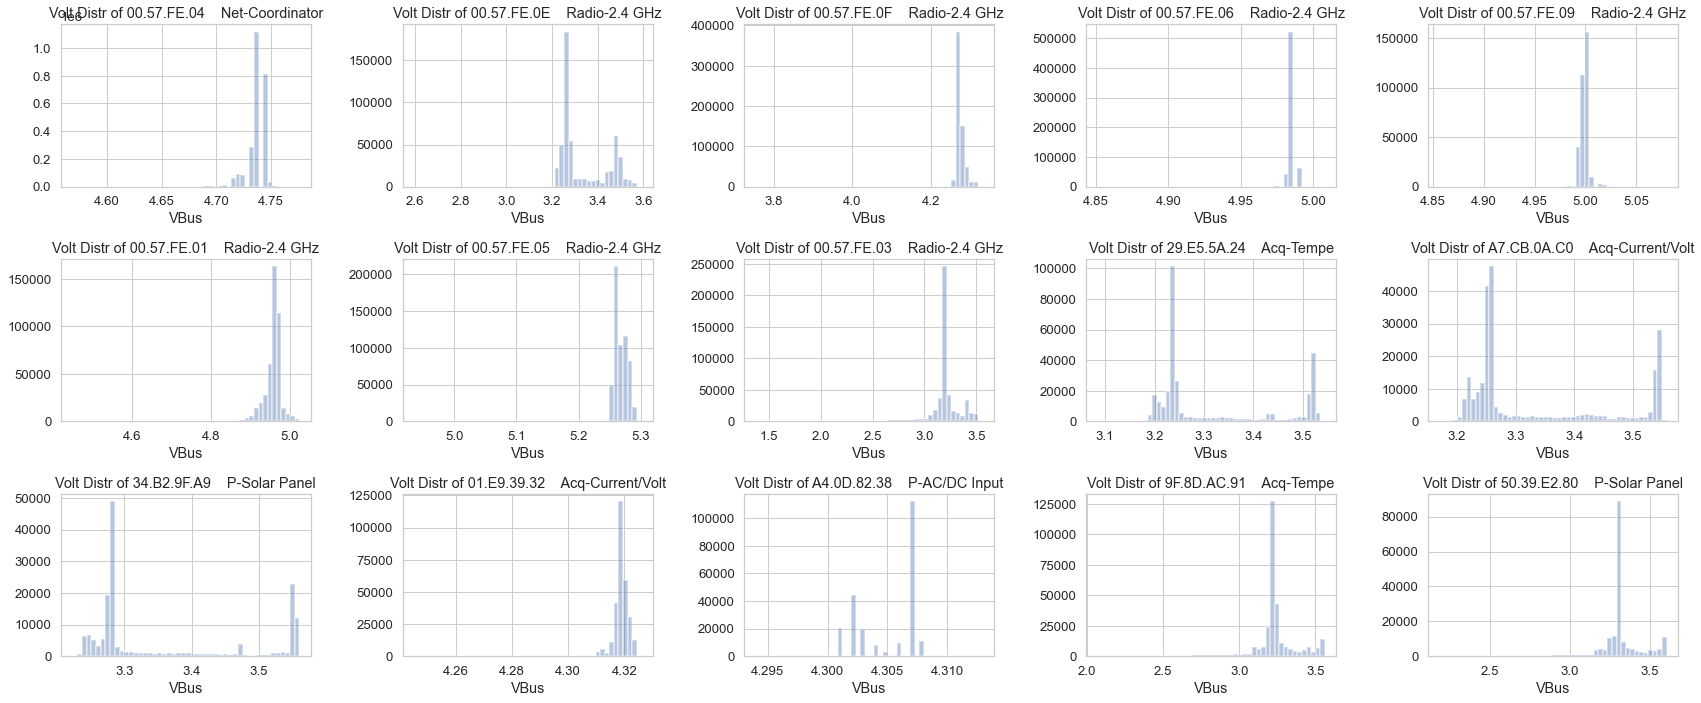

In [390]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(24,10), sharex=False)
#fig.delaxes(axes[3,3])
for i, ax in zip(Modules, axes.flat):
    sns.distplot(df[df['Module'] == i]['VBus'], kde=False, ax=ax, hist_kws={"linewidth":2})
    #sns.distplot(df[df['Module'] == i]['VBus']/df[df['Module'] == i]['VBus'].max(), kde=False, ax=ax, hist_kws={"linewidth":2}, color='r')   # UNCOMMENT TO NORMALIZE THE DATA
    ax.set_title('Volt Distr of {}    {}'.format(i, Modules[i]))
    #ax.set_xticks(np.arange(0,1,step=0.1))
plt.tight_layout()

As we can see, there is almost no variation in Voltage Bus. Modules connected to the line presents almost no variation and other modules like those connected to other sources, like the solar panels presents more variation.

#### Exploring Distribution of other features over different Modules.

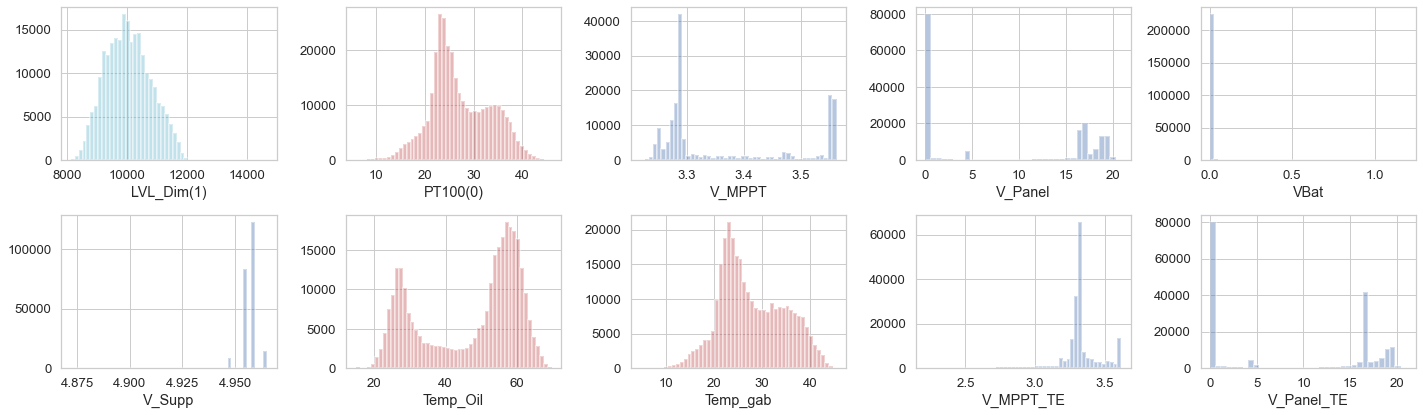

In [129]:
fig, axarr = plt.subplots(nrows=2, ncols=5, figsize=(20,6), )
sns.distplot(a = df[df['Module']=='A7.CB.0A.C0']['LVL_Dim(1)'], kde=False, ax=axarr[0,0], color='c', hist_kws={"linewidth":2})
sns.distplot(a = df[df['Module']=='29.E5.5A.24']['PT100(0)'], kde=False, ax=axarr[0,1], color='r', hist_kws={"linewidth":2})
sns.distplot(a = df[df['Module']=='34.B2.9F.A9']['V_MPPT'], kde=False, ax=axarr[0,2], color='b', hist_kws={"linewidth":2})
sns.distplot(a = df[df['Module']=='34.B2.9F.A9']['V_Panel'], kde=False, ax=axarr[0,3], color='b', hist_kws={"linewidth":2})
sns.distplot(a = df[df['Module']=='A4.0D.82.38']['VBat'], kde=False, ax=axarr[0,4], color='b', hist_kws={"linewidth":2})
sns.distplot(a = df[df['Module']=='A4.0D.82.38']['V_Supp'], kde=False, ax=axarr[1,0], color='b', hist_kws={"linewidth":2})
sns.distplot(a = df[df['Module']=='9F.8D.AC.91']['Temp_Oil'], kde=False, ax=axarr[1,1], color='r', hist_kws={"linewidth":2})
sns.distplot(a = df[df['Module']=='9F.8D.AC.91']['Temp_gab'], kde=False, ax=axarr[1,2], color='r', hist_kws={"linewidth":2})
sns.distplot(a = df[df['Module']=='50.39.E2.80']['V_MPPT_TE'], kde=False, ax=axarr[1,3], color='b', hist_kws={"linewidth":2})
sns.distplot(a = df[df['Module']=='50.39.E2.80']['V_Panel_TE'], kde=False, ax=axarr[1,4], color='b', hist_kws={"linewidth":2})
plt.tight_layout()

### **Feature Engineering from Date**

Let's explore how this features variate over time. For that, i added columns with hour, month, year, day, and week. The columns are created using the same Timestamp corresponding with the data. The Temperature and voltages are going to be more examined since is present in avery module, the rest is not.

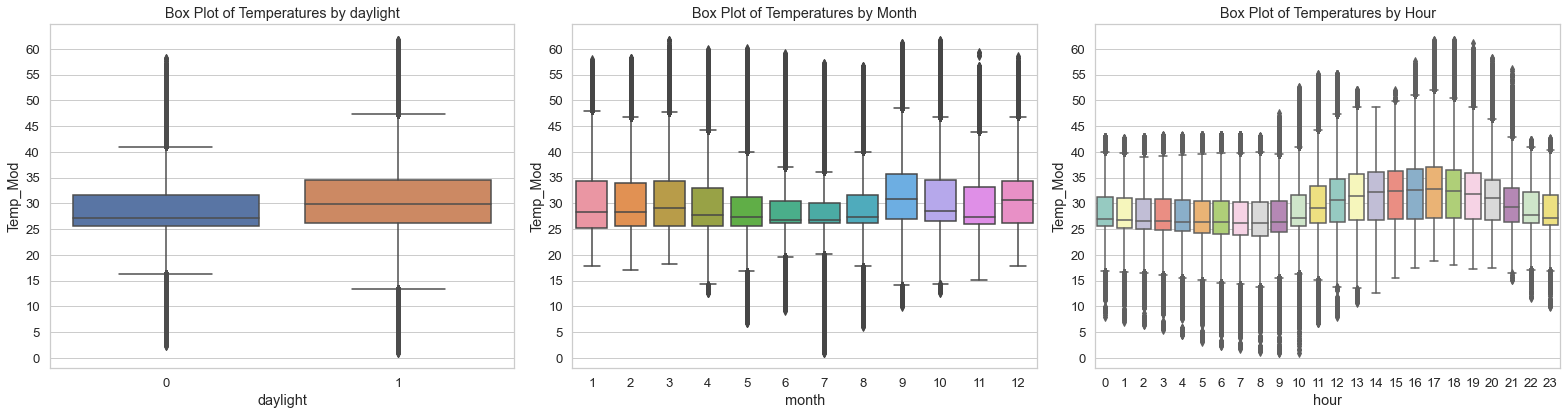

In [401]:
fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(22,6), sharex=False)
axarr[0].set_title('Box Plot of Temperatures by daylight')
axarr[0].set_yticks(ticks=np.arange(0,65,step=5))
sns.boxplot(x='daylight',y='Temp_Mod',data=df, ax=axarr[0])
axarr[1].set_title('Box Plot of Temperatures by Month')
axarr[1].set_yticks(ticks=np.arange(0,65,step=5))
sns.boxplot(x='month',y='Temp_Mod',data=df, ax=axarr[1])
axarr[2].set_title('Box Plot of Temperatures by Hour')
axarr[2].set_yticks(ticks=np.arange(0,65,step=5))
sns.boxplot(x='hour',y='Temp_Mod',data=df, ax=axarr[2], palette='Set3')
plt.tight_layout()

**We can also see the variation of a specific module in time. For example, taking module 9F.8D.AC.91**

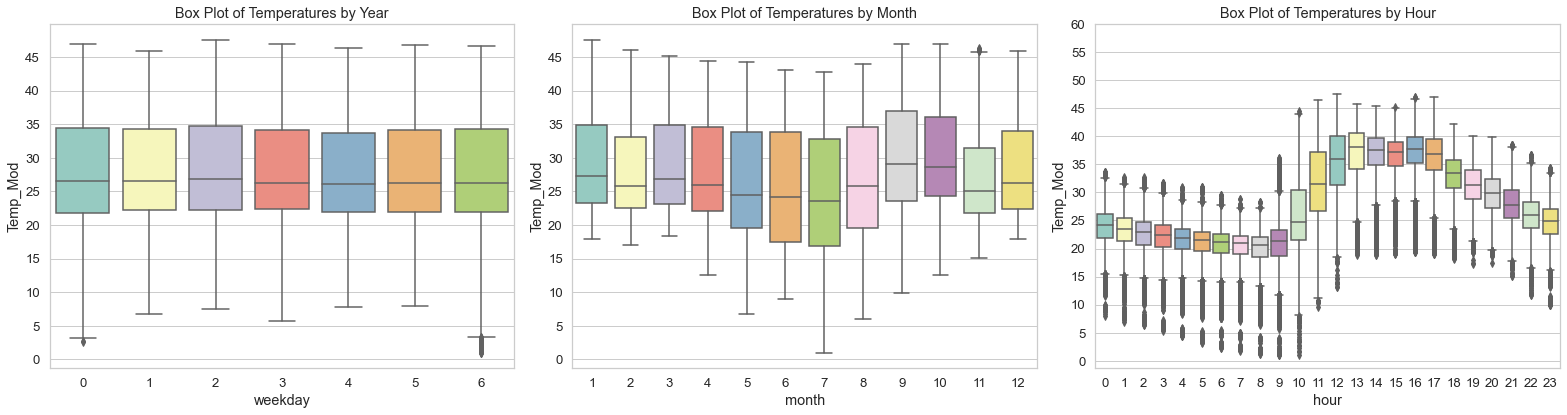

In [404]:
fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(22,6), sharex=False)
axarr[0].set_title('Box Plot of Temperatures by Year')
axarr[0].set_yticks(ticks=np.arange(0,65,step=5))
sns.boxplot(x='weekday',y='Temp_Mod',data=df[df['Module']=='9F.8D.AC.91'], ax=axarr[0], palette='Set3')
axarr[1].set_title('Box Plot of Temperatures by Month')
axarr[1].set_yticks(ticks=np.arange(0,65,step=5))
sns.boxplot(x='month',y='Temp_Mod',data=df[df['Module']=='9F.8D.AC.91'], ax=axarr[1], palette='Set3')
axarr[2].set_title('Box Plot of Temperatures by Hour')
axarr[2].set_yticks(ticks=np.arange(0,65,step=5))
sns.boxplot(x='hour',y='Temp_Mod',data=df[df['Module']=='9F.8D.AC.91'], ax=axarr[2], palette='Set3')
axarr[2].set_yticks(ticks=np.arange(0,65,step=5))
plt.tight_layout()

**We can see how the temperatures start to increase after 8:00 until 17:00, that starts to go down, this corresponds with the day cicle, also we can see how the temperatures are lower in months of winter and higher in summer.**

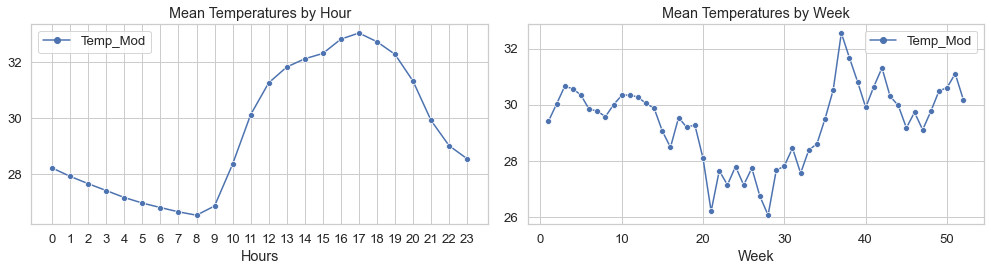

In [144]:
fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,4), sharex=False)
ax0.set_title('Mean Temperatures by Hour')
data = df.groupby('hour').mean()[['Temp_Mod']]
sns.lineplot(data = data, markers=True,ax=ax0)
ax0.set_xticks(np.arange(0,24, step=1))
ax0.set_xlabel('Hours')

ax1.set_title('Mean Temperatures by Week')
data=df.groupby('week').mean()[['Temp_Mod']]
sns.lineplot(data = data, markers=True,ax=ax1)
ax1.set_xlabel('Week')
plt.tight_layout()

**Next is the Boxplot of all the features, first by month and then by hour.**

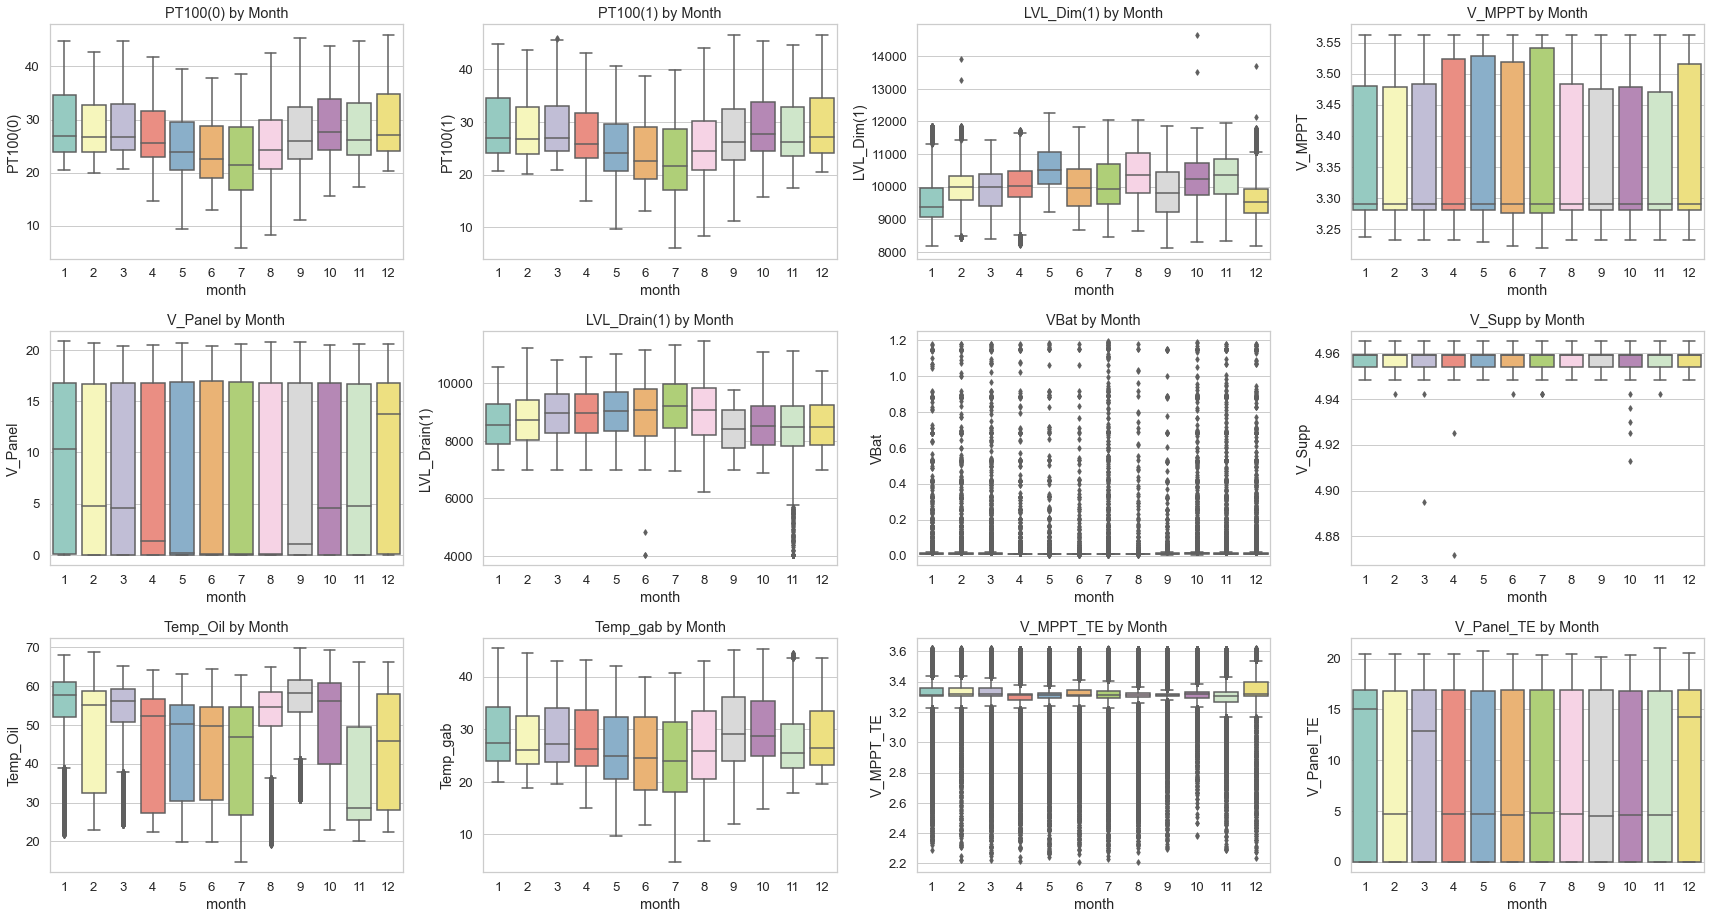

In [150]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(24,13), sharex=False)
#fig.delaxes(axes[3,3])
for i,ax in zip(df.columns[10:], axes.flat):
    ax.set_title('{} by Month'.format(i))
    sns.boxplot(x='month',y= i,data=df, ax=ax, palette='Set3', fliersize=4)
plt.tight_layout()

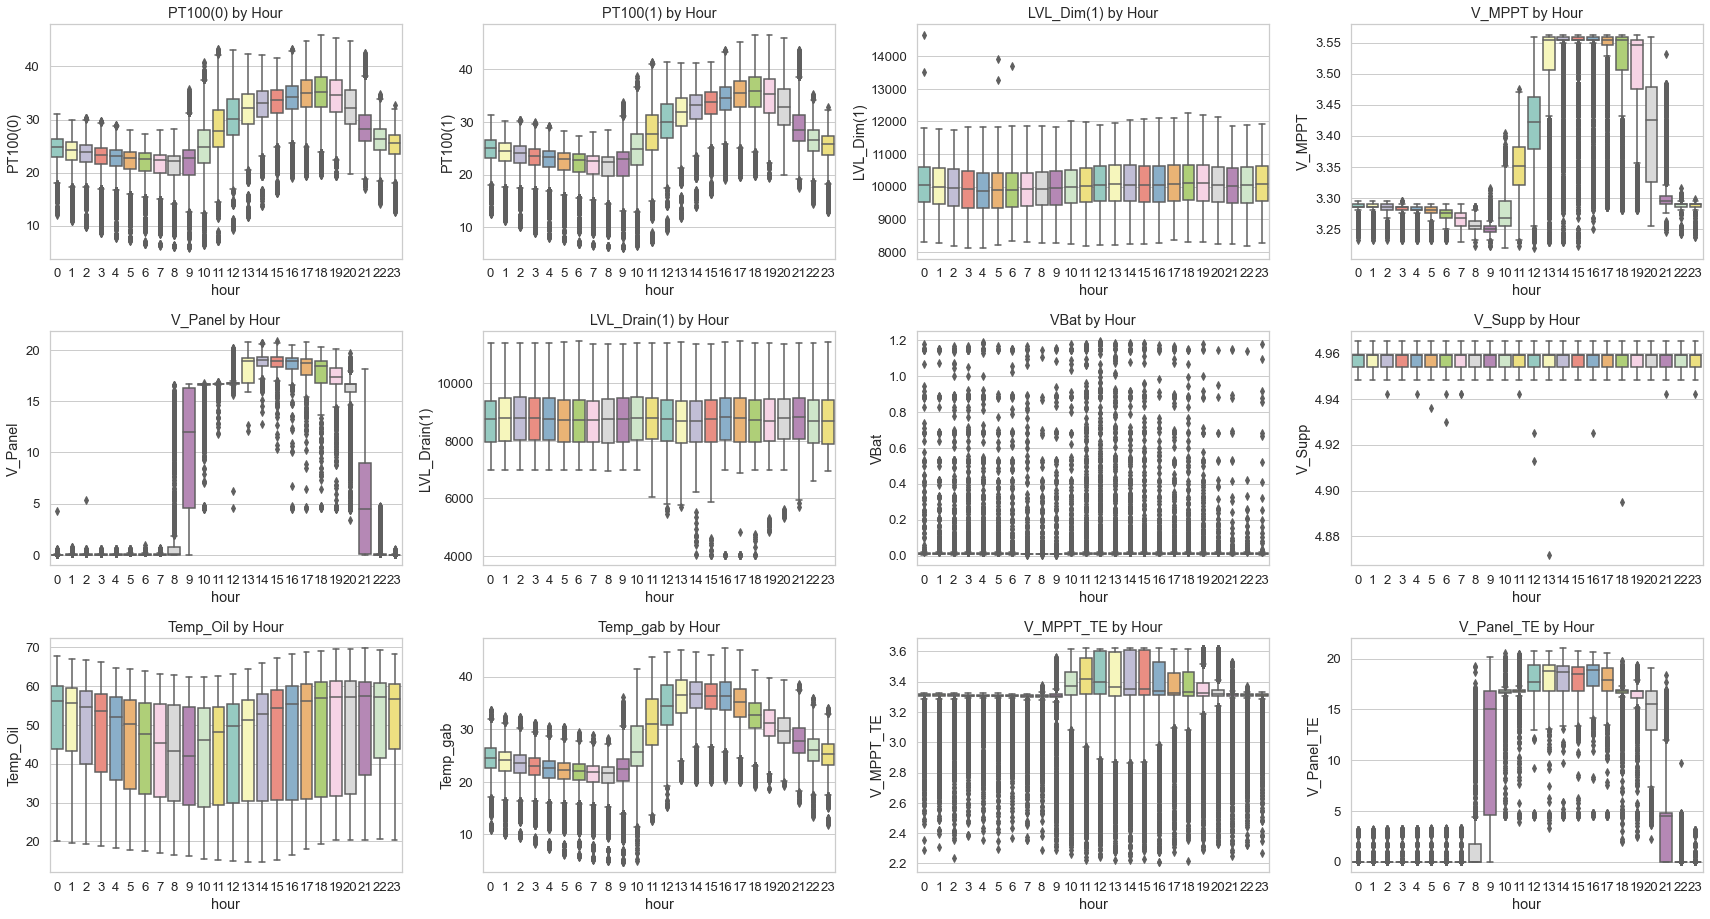

In [151]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(24,13), sharex=False)
for i,ax in zip(df.columns[10:], axes.flat):
    ax.set_title('{} by Hour'.format(i))
    sns.boxplot(x='hour',y= i,data=df, ax=ax, palette='Set3')
plt.tight_layout()

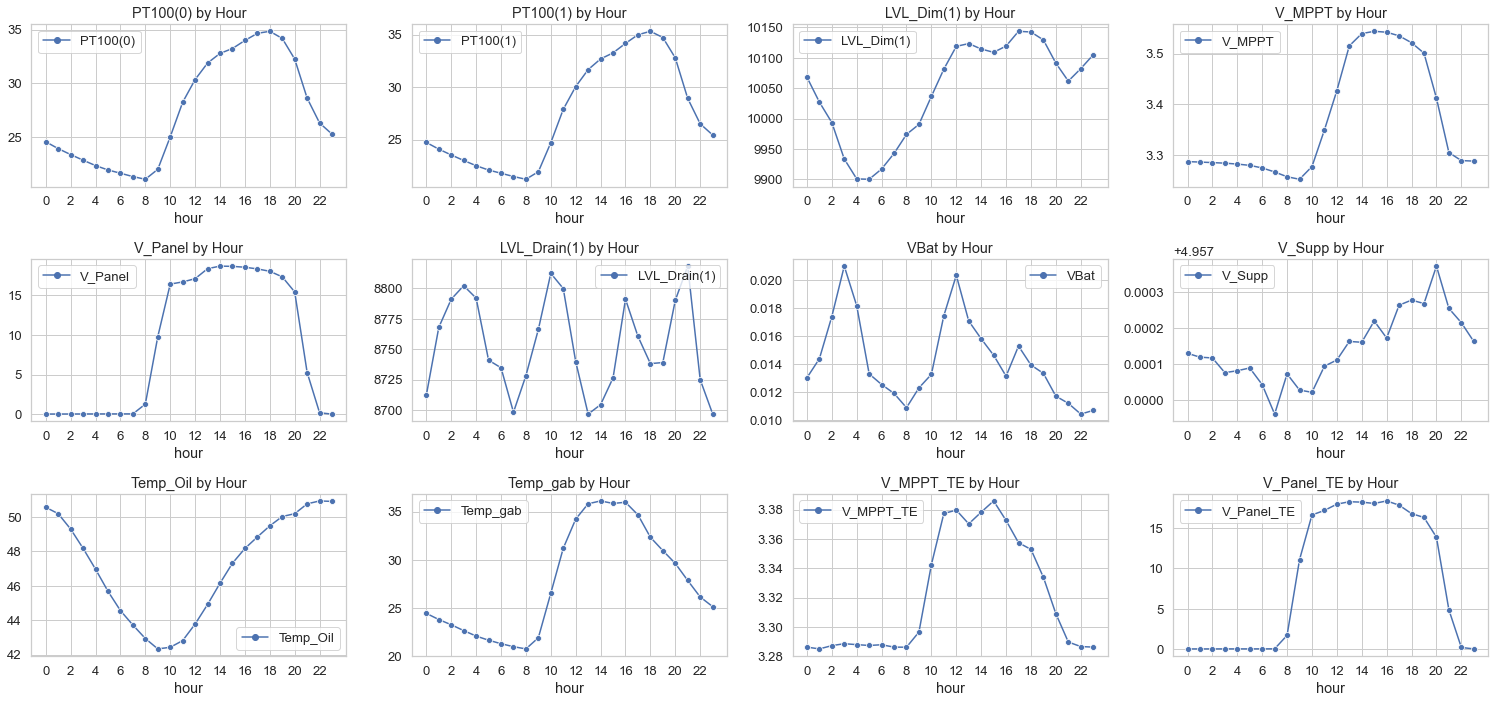

In [152]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(21,10), sharex=False)
for i,ax in zip(df.columns[10:], axes.flat):
    ax.set_title('{} by Hour'.format(i))
    data=df.groupby('hour').mean()[[i]]
    sns.lineplot(data=data, markers=True,ax=ax, err_style='bars')
    ax.set_xticks(np.arange(0,24,2))
plt.tight_layout()

### **Explore the correlation between the different features**

`pd.Corr()` Computes pairwise correlation of columns, excluding NA/null values. The NaN values are ignored, this makes sense because, for example, the voltage from the solar panels is not related at all with the temperature from the PT100 since they are different modules in different locations. Pearson correlation is used. Used a heatmap to see the values better. Empty spaces are NaN values, meaning no correaltion at all.

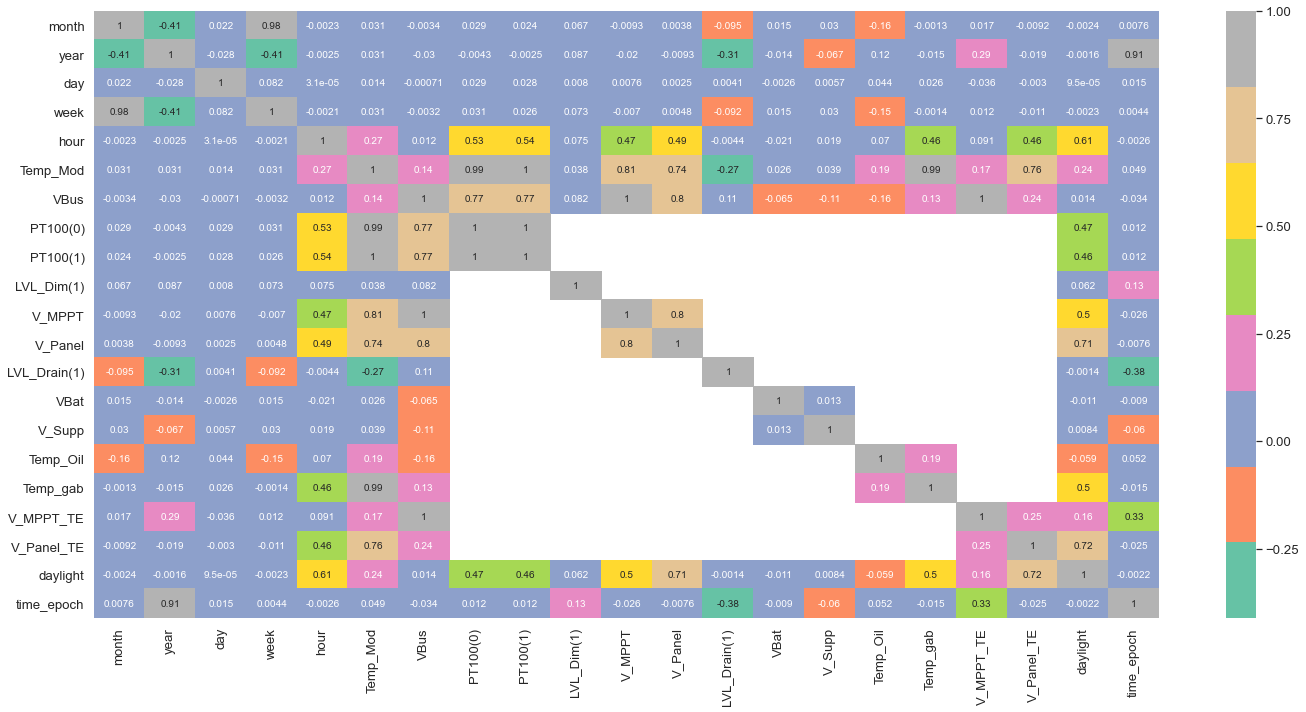

In [45]:
correlation = df.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(correlation, annot=True, cmap='Set2')
plt.tight_layout()

#### Next is a graph of the correlation against temperature and voltage sorted. Better corr to the right.

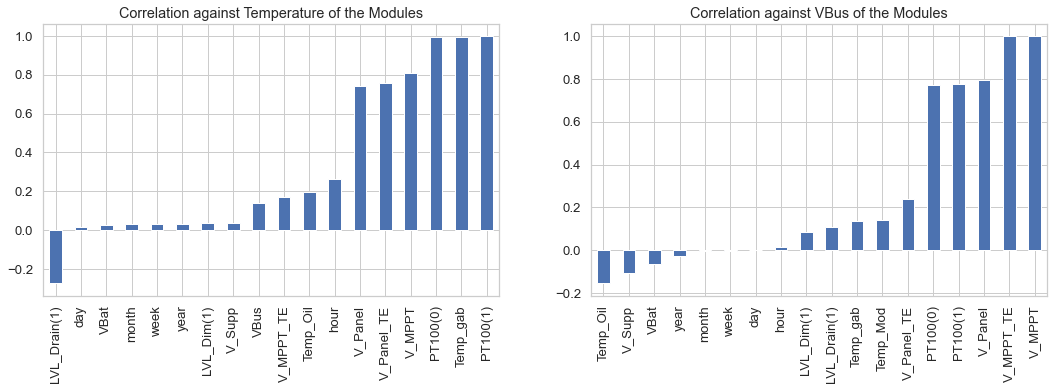

In [166]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
correlation['Temp_Mod'].sort_values()[:-1].plot(kind='bar', ax=axarr[0])
axarr[0].set_title('Correlation against Temperature of the Modules')
correlation['VBus'].sort_values()[:-1].plot(kind='bar', ax=axarr[1])
axarr[1].set_title('Correlation against VBus of the Modules')
plt.show()

#### Now let's explore the correlations graphically using a scatter plot

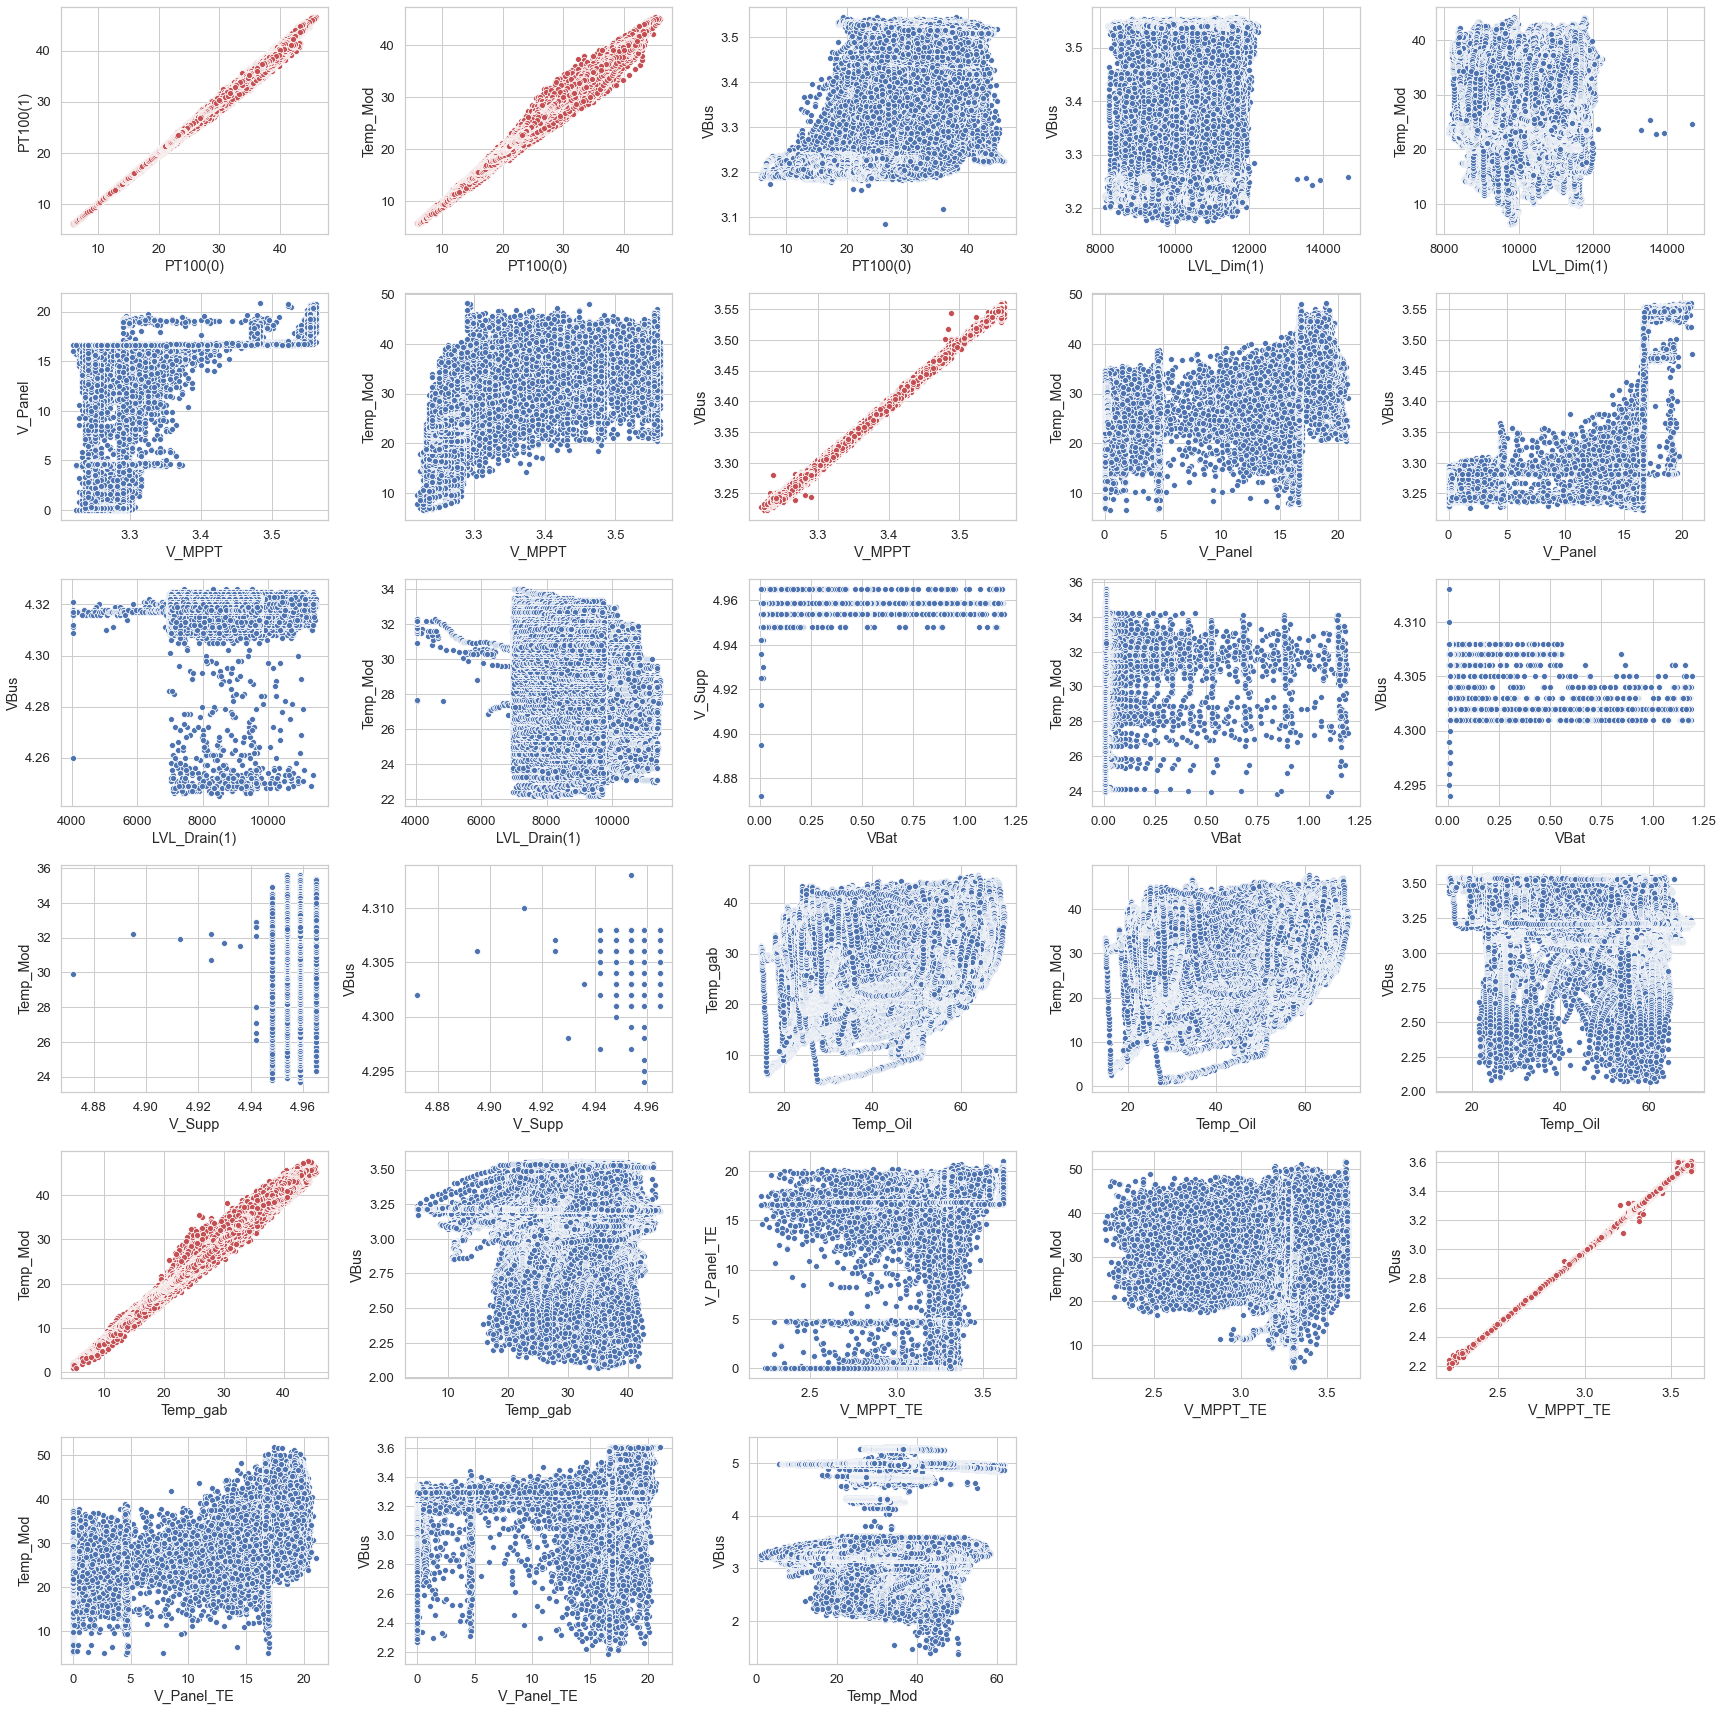

In [168]:
fig, axarr = plt.subplots(nrows=6, ncols=5, figsize=(24,24))
fig.delaxes(axarr[5,3])
fig.delaxes(axarr[5,4])
sns.scatterplot(x='PT100(0)',y='PT100(1)',data=df, ax=axarr[0,0], color='r')
sns.scatterplot(x='PT100(0)',y='Temp_Mod',data=df, ax=axarr[0,1], color='r')
sns.scatterplot(x='PT100(0)',y='VBus',data=df, ax=axarr[0,2])
sns.scatterplot(x='LVL_Dim(1)',y='VBus',data=df, ax=axarr[0,3])
sns.scatterplot(x='LVL_Dim(1)',y='Temp_Mod',data=df, ax=axarr[0,4])
sns.scatterplot(x='V_MPPT',y='V_Panel',data=df, ax=axarr[1,0])
sns.scatterplot(x='V_MPPT',y='Temp_Mod',data=df, ax=axarr[1,1])
sns.scatterplot(x='V_MPPT',y='VBus',data=df, ax=axarr[1,2], color='r')
sns.scatterplot(x='V_Panel',y='Temp_Mod',data=df, ax=axarr[1,3])
sns.scatterplot(x='V_Panel',y='VBus',data=df, ax=axarr[1,4])
sns.scatterplot(x='LVL_Drain(1)',y='VBus',data=df, ax=axarr[2,0])
sns.scatterplot(x='LVL_Drain(1)',y='Temp_Mod',data=df, ax=axarr[2,1])
sns.scatterplot(x='VBat',y='V_Supp',data=df, ax=axarr[2,2])
sns.scatterplot(x='VBat',y='Temp_Mod',data=df, ax=axarr[2,3])
sns.scatterplot(x='VBat',y='VBus',data=df, ax=axarr[2,4])
sns.scatterplot(x='V_Supp',y='Temp_Mod',data=df, ax=axarr[3,0])
sns.scatterplot(x='V_Supp',y='VBus',data=df, ax=axarr[3,1])
sns.scatterplot(x='Temp_Oil',y='Temp_gab',data=df, ax=axarr[3,2])
sns.scatterplot(x='Temp_Oil',y='Temp_Mod',data=df, ax=axarr[3,3])
sns.scatterplot(x='Temp_Oil',y='VBus',data=df, ax=axarr[3,4])
sns.scatterplot(x='Temp_gab',y='Temp_Mod',data=df, ax=axarr[4,0], color='r')
sns.scatterplot(x='Temp_gab',y='VBus',data=df, ax=axarr[4,1])
sns.scatterplot(x='V_MPPT_TE',y='V_Panel_TE',data=df, ax=axarr[4,2])
sns.scatterplot(x='V_MPPT_TE',y='Temp_Mod',data=df, ax=axarr[4,3])
sns.scatterplot(x='V_MPPT_TE',y='VBus',data=df, ax=axarr[4,4], color='r')
sns.scatterplot(x='V_Panel_TE',y='Temp_Mod',data=df, ax=axarr[5,0])
sns.scatterplot(x='V_Panel_TE',y='VBus',data=df, ax=axarr[5,1])
sns.scatterplot(x='Temp_Mod',y='VBus',data=df, ax=axarr[5,2])
plt.tight_layout()

## **Visualizing the features as Time Series**

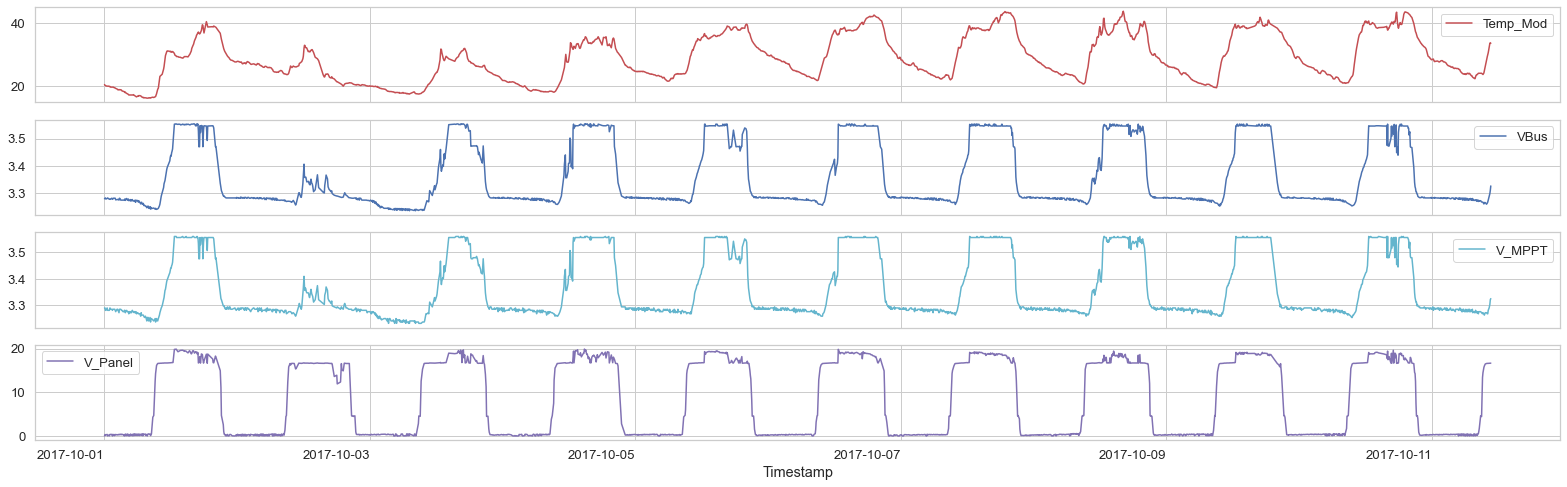

In [142]:
module = df['Module'].unique()[9]
subset = df[df['Module'] == module][:2000]
subset = subset.dropna(axis=1, how='all')

fig, axx = plt.subplots(4, 1, figsize=(22,7), sharex=True)
subset.plot(x ='Timestamp', y = 'Temp_Mod', ax=axx[0], color='r')
subset.plot(x ='Timestamp', y = 'VBus', ax=axx[1], color='b')
subset.plot(x ='Timestamp', y = 'V_MPPT', ax=axx[2], color='c')
subset.plot(x ='Timestamp', y = 'V_Panel', ax=axx[3], color='m')
plt.xticks(rotation=0)
plt.tight_layout()

The first 4 time series corresponds to the features of a single module, Radios only have 2 componensts, others 3 or 4. We can see that 200 samples correspond to 1 day approximatly.

**Any time series may be split into the following components: Base Level + Trend + Seasonality + Error**. We can see that the time series reflects a clear seasonality and no trend indication.

## **Exploring RSSI data from modules**

Received signal strength indicator (RSSI) as the name suggests is a measure of the strength of a received wireless signal. It is obvious that the power of the received signal would decrease with distance. To be precise, power $P_R$ of the received signal is inversely proportional to the square of the distance between the receiver and the transmitter. RSSI can then be defined as the ratio of received power $P_R$ to the reference power $P_{REF}$. Reference power $P_{REF}$ is typically taken as 1 mW, it can be defined as:

$$RSSI = 10log \dfrac{P_{RX}}{P_{REF}}$$

Where $P_{Rx}$ is:
$$P_{Rx} = P_{Tx}G_{Tx}G_{Rx}(\dfrac{\theta}{4 \pi d})^2$$

Where $P_{Tx}$ is the transmission power of sender, $P_{Rx}$ is the remaining power of the wave at the receiver, $G_{Tx}$ and $G_{Rx}$ are the gain of transmitter and receiver, respectively, $\theta$ is the wave length, and lastly d is the distance between the sender and the receiver. Because of its relationship with distance, ideally RSSI would be a very accurate measure of the receiver’s distance from the source. It, however, can get affected from a number of factors such as reflections from objects, electromagnetic fields, diffraction, refraction, and other multipath effects

As a note, the default transmitter output power level reaching the radio omnidirectional (monopole) antenna was set to 11 dBm. All the radios were set as routers (relays), so each one was able to establish different routes to communicate up to the coordinator. The coordinator uploaded the radios data to a local database.

A first issue to be addressed is related to the noisy environment regarding industrial locations, such as power plants. Due to the presence of high-power equipment, EMI may be generated which can lead to misreadings in the RSSI values, generally **registered as abrupt peaks resembling spikes.** Those spikes should be filtered out as they are not related to changes in the communication channel.

A second issue is related to the transmission power of each node. Since the radios are able to automatically increase their transmission power to improve their link quality, these increments are registered by other radios as transitory pulses in the RSSI. These pulses need to be removed, otherwise, this could lead to miscalculation of the path-loss coefficient. The path loss (PL), which estimates the power attenuation with the distance (d), is described by:

$$PL(db) = PL(d_{0}) + 10nlog(\dfrac{d}{d_0})$$

where **n** is the path-loss coefficient, which depends on the propagation environment, and $d_0$ is a reference distance close to the transmitter. Also the path loss measured can be calculated as:

$$PL_m(d)[dB] = P_{tx} − RSSI$$

The next step, previous to the channel parameters calculation, concerns the discard of unreliable data. This is necessary due to eventual hardware issues or non-stable communication between nodes. Unstable connections are noticed when the corresponding RSSI registered data is very low or even sporadic compared to the rest of the stable links. Based on the RSSI registered values by each radio pairs, and on the periodicity of these data, some measurements can be considered as outliers, and the information of the corresponding nodes should be discarded.

Finally, the data can be used for the extraction of the parameters of the channel model. First, the instantaneous RSSI data for each node, which was measured and recorded at specific time intervals, is averaged over convenient measurement periods according to the time window for which the parameters are to be used. For example, an hour basis average may be useful to keep a record of the channel behavior during a day. After this, these values are used to obtain the large-scale communication channel parameters, which includes the path-loss coefficient and the shadowing deviation. The choice of the channel model may be any that better suits the industrial environment.<br>(Taken from the paper)

The data is arrange as follows:<br>
For every receiver there are 7 transmitter, these trasmitters can be columns filled with NaN values, which means that radio doesn't get data from those empty columns, so when trating a receiver these columns must be dropped (only if the entire column is NaN).

In [299]:
# Loading the data
df_powers = pd.read_csv('Data/Modules_Powers_2.csv', usecols=columns_radio2, parse_dates=['Timestamp'], 
                 dtype={'P_Tx1(dbm)':float, 'P_Tx2(dbm)':float, 'P_Tx3(dbm)':float,
                        'P_Tx4(dbm)':float, 'P_Tx5(dbm)':float, 'P_Tx6(dbm)':float,
                       'Tx1':str, 'Tx2':str, 'Tx3':str, 'Tx4':str, 'Tx5':str, 'Tx6':str,
                       'Tx7':str, 'P_Tx7(dbm)':float})
RADIOS = df.Module.unique()[:7]
RADIOS = np.append(RADIOS, df.Module.unique()[-1])

In [300]:
POWERS = ['P_Tx1(dbm)', 'P_Tx2(dbm)', 'P_Tx3(dbm)', 'P_Tx4(dbm)', 'P_Tx5(dbm)', 'P_Tx6(dbm)', 'P_Tx7(dbm)']
RECEIVERS = np.array(df_powers['Receiver'].unique())
df_powers.set_index('Timestamp', drop=True, inplace=True)
df_powers.head()

Module             Type    Receiver         Tx1  \
Timestamp                                                                   
2017-10-01 00:00:05  00.57.FE.04  Net-Coordinator  0x0057FE04  0x0057FE09   
2017-10-01 00:00:42  00.57.FE.04  Net-Coordinator  0x0057FE04  0x0057FE09   
2017-10-01 00:01:13  00.57.FE.04  Net-Coordinator  0x0057FE04  0x0057FE09   
2017-10-01 00:01:42  00.57.FE.04  Net-Coordinator  0x0057FE04  0x0057FE09   
2017-10-01 00:02:05  00.57.FE.04  Net-Coordinator  0x0057FE04  0x0057FE09   

                     P_Tx1(dbm)         Tx2  P_Tx2(dbm)  Tx3  P_Tx3(dbm)  Tx4  \
Timestamp                                                                       
2017-10-01 00:00:05       -72.0  0x0057FE01       -75.0  NaN         NaN  NaN   
2017-10-01 00:00:42       -72.0  0x0057FE01       -75.0  NaN         NaN  NaN   
2017-10-01 00:01:13       -72.0  0x0057FE01       -75.0  NaN         NaN  NaN   
2017-10-01 00:01:42       -72.0  0x0057FE01       -75.0  NaN         NaN  NaN   
2017-10-01 00:02:05       -72.0  0x0057FE01       -75.0  NaN         NaN  NaN   

                     P_Tx4(dbm)  Tx5  P_Tx5(dbm)  Tx6  P_Tx6(dbm)  Tx7  \
Timestamp                                                                
2017-10-01 00:00:05         NaN  NaN         NaN  NaN         NaN  NaN   
2017-10-01 00:00:42         NaN  NaN         NaN  NaN         NaN  NaN   
2017-10-01 00:01:13         NaN  NaN         NaN  NaN         NaN  NaN   
2017-10-01 00:01:42         NaN  NaN         NaN  NaN         NaN  NaN   
2017-10-01 00:02:05         NaN  NaN         NaN  NaN         NaN  NaN   

                     P_Tx7(dbm)  
Timestamp                        
2017-10-01 00:00:05         NaN  
2017-10-01 00:00:42         NaN  
2017-10-01 00:01:13         NaN  
2017-10-01 00:01:42         NaN  
2017-10-01 00:02:05         NaN

#### Description of some characteristics for transmitter

We can see that the max value of power in some transmitters is -9 dbm (from the description table before), this is a wrong data,  an **RSSI of −9 dBm** corresponds to the maximum value of power that can be registered by node radios. In this case, they also represented an abandoned communication between two neighbor radios. We can remove them or create a label indicating the meaning of this value for a future classification problem. The - dbm values are spikes that last for a very short period of time.

In [262]:
#df_powers.groupby(['Receiver']).describe()
df_powers.describe()
# Dropping rows with -9 DBM, considering this value as an error
#df_powers = drop_power(df_powers, Powers)
#df_powers.describe().loc[['max']]

P_Tx1(dbm)  P_Tx2(dbm)  P_Tx3(dbm)  P_Tx4(dbm)   P_Tx5(dbm)  \
count  6.1152e+06  5.0174e+06  3.0193e+06  1.2527e+06  800993.0000   
mean  -6.0775e+01 -6.3932e+01 -6.8191e+01 -7.0503e+01     -72.1400   
std    1.0226e+01  1.3515e+01  1.3039e+01  1.1980e+01      10.3875   
min   -9.4000e+01 -9.6000e+01 -9.5000e+01 -9.5000e+01     -94.0000   
25%   -6.9000e+01 -7.5000e+01 -7.7000e+01 -7.9000e+01     -78.0000   
50%   -6.0000e+01 -6.7000e+01 -7.2000e+01 -7.3000e+01     -75.0000   
75%   -5.1000e+01 -5.1000e+01 -6.0000e+01 -6.4000e+01     -68.0000   
max   -9.0000e+00 -9.0000e+00 -9.0000e+00 -9.0000e+00      -9.0000   

        P_Tx6(dbm)   P_Tx7(dbm)  
count  398609.0000  105121.0000  
mean      -74.3443     -75.1843  
std         9.7100       8.6803  
min       -94.0000     -94.0000  
25%       -80.0000     -79.0000  
50%       -76.0000     -77.0000  
75%       -70.0000     -72.0000  
max        -9.0000      -9.0000

### Visualizing as Time Series

To visualize the time series (the data in time) first we need to separate the data into receivers, then we are going to select a time frame. But there is a problem, some times the transmitter changes from Transmitter 1 to Transmitter 2 or others, meaning that the data from the time series (received data from Receiver X) can be sparsed into different columns, therefor, first we need to arange this. If we continue without doing this, the time series is going to have a lot of missing data (not NaN values but missing timestamps). The problem can be seen in the next figure (if `plot_entire=True`), which is a plot of the entire RSSI data from the Neighbour 1. In there we can see how from the final days of january to mid february the data is very strange. This is because there is some mixed data from others radios, with different powers. So, in order to build the correct time serie we need to take the data from every transmitter involved and create the correct time series for them. 

Taking the first module (Coordinator) we can see that data from module 00.57.FE.05 is more stable, with few spikes and is present the entire time. There are also some missing data (NaN values) for every transmitter. The data from receivers 09 and 01 are even more unstable and presenting many spikes.

 **Radio RC is the Coordinator (00.57.FE.04). <br>
   Radio R1 is module 00.57.FE.09 <br>
   Radio R4 is module 00.57.FE.01 <br>
   Radio R5 is in Montante UG5 and module 00.57.FE.0E <br>
   Radio R2 is in Transformador Elevador and module 00.57.FE.03 <br>
   Radio R6 is in Poço de Drenagem A and module 00.57.FE.0F <br>
   Radio R3 is also in Poço de Drenagem A but is a Radio, module 00.57.FE.05 or 00.57.FE.06.**

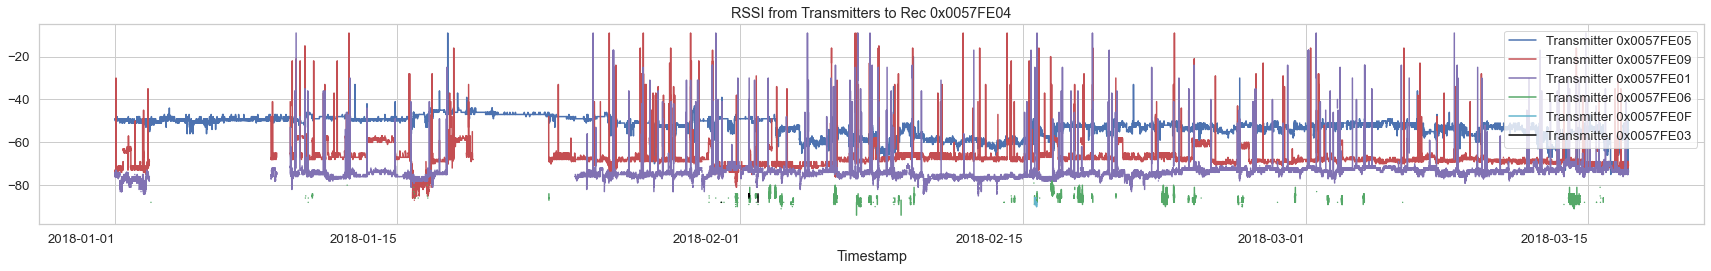

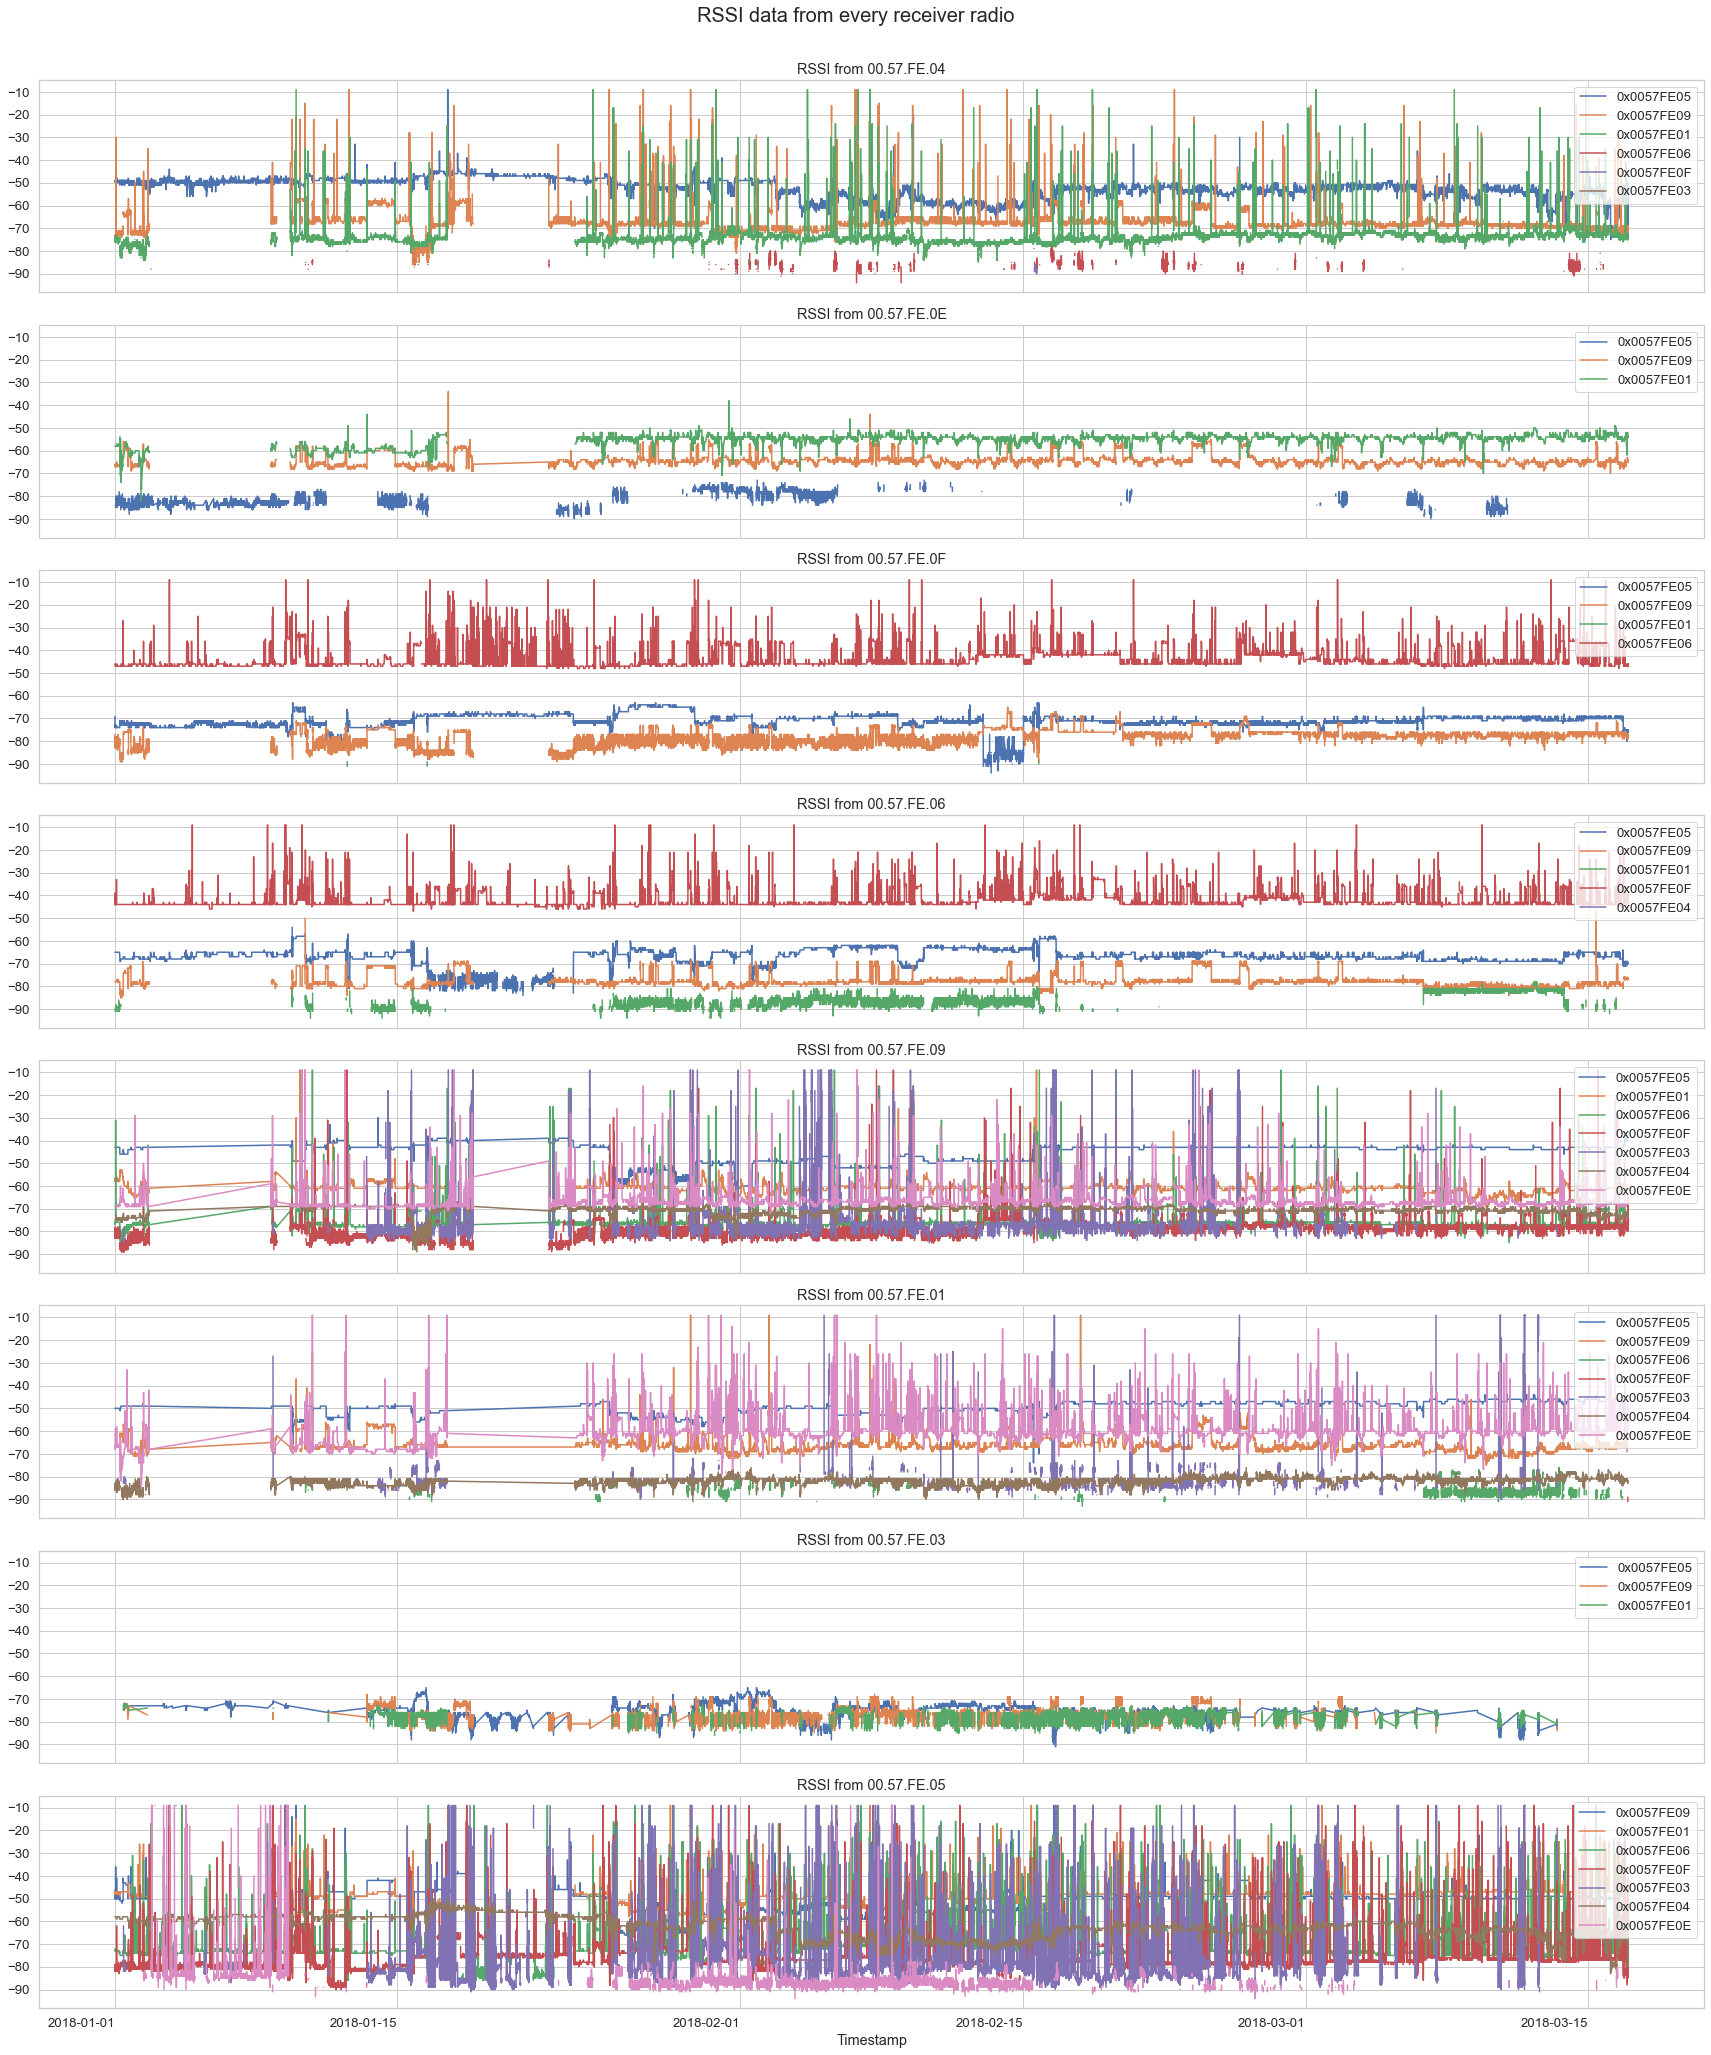

In [405]:
start_date = '2018-01-01'
end_date='2018-03-16'
# This is for a single receiver and if it's needed to divide it into transmitters
# if plot_entire=True then plots the entire neighbour, as before, to show the problem stated above.
subset, serie, transmitters, Tx = arange_RSSI_serie(df_powers, receiver=0, start_date=start_date, end_date=end_date, joint=True, sharex=True, plot_entire=False)
dff = create_RSSI_dataframe(df_powers, plot=True, start_date=start_date, end_date=end_date, raw=True, resample_time=None)
#plt.figure(figsize=(24,5));sns.lineplot(data=dff[dff['Receiver']=='00.57.FE.03'].dropna(axis=1, how='all').drop('Receiver',axis=1))

In [331]:
dff = add_date_features(dff)
dff = dff[['Receiver','0x0057FE04', '0x0057FE0E','0x0057FE0F', '0x0057FE06',
           '0x0057FE09', '0x0057FE01', '0x0057FE03', '0x0057FE05', 'hour',
           'day','month','week','weekday','daylight']]
dff.head()

Receiver  0x0057FE04  0x0057FE0E  0x0057FE0F  \
Timestamp                                                              
2018-01-01 00:00:19  00.57.FE.04         NaN         NaN         NaN   
2018-01-01 00:00:49  00.57.FE.04         NaN         NaN         NaN   
2018-01-01 00:01:19  00.57.FE.04         NaN         NaN         NaN   
2018-01-01 00:01:49  00.57.FE.04         NaN         NaN         NaN   
2018-01-01 00:02:19  00.57.FE.04         NaN         NaN         NaN   

                     0x0057FE06  0x0057FE09  0x0057FE01  0x0057FE03  \
Timestamp                                                             
2018-01-01 00:00:19         NaN       -74.0       -75.0         NaN   
2018-01-01 00:00:49         NaN       -74.0       -76.0         NaN   
2018-01-01 00:01:19         NaN       -74.0       -76.0         NaN   
2018-01-01 00:01:49         NaN       -74.0       -76.0         NaN   
2018-01-01 00:02:19         NaN       -74.0       -76.0         NaN   

                     0x0057FE05  hour  day  month  week  weekday  daylight  
Timestamp                                                                   
2018-01-01 00:00:19       -49.0     0    1      1     1        0         0  
2018-01-01 00:00:49       -49.0     0    1      1     1        0         0  
2018-01-01 00:01:19       -49.0     0    1      1     1        0         0  
2018-01-01 00:01:49       -49.0     0    1      1     1        0         0  
2018-01-01 00:02:19       -49.0     0    1      1     1        0         0

### Amounth of data transmitted by neighbour

First is the amounth of data received by Radio. It can be seen that the one with more data is the Coordinator.<br>

Next is the amounth of data by transmitter in every neighbour. We can see how the quantities are lower as we increase in neighbour. Neighbour 1 presents the biggest amounth of data, almost all from module 0x0057FE05 to coordinator. The countplot of the Transmitters data by module only tells us that the biggest amounth of data is concentrated first 2 Transmitters. This is because every radio receives data from at least two modules, less radios from 3 modules and even less from all the modules. This is due to the Mesh Topology of the network.

Then let's check the amounth of data transmitted to every receiver and which radios intervine. As we can see, the biggest amounth of data is in neighbour 1 (TX1) and comes from module 05.

In the 3rd figure we can see a **Box Plot** of the RSSI in receiver by transmitter. We can conclude with this, for example, that transmitters 03, 06 and 0F are further from RC than the rest sice the RSSI mean is lower than the rest and close to -90 dbm. We can also see how modules 05, 09 and 01 are the most constant one since they send data to every other module.

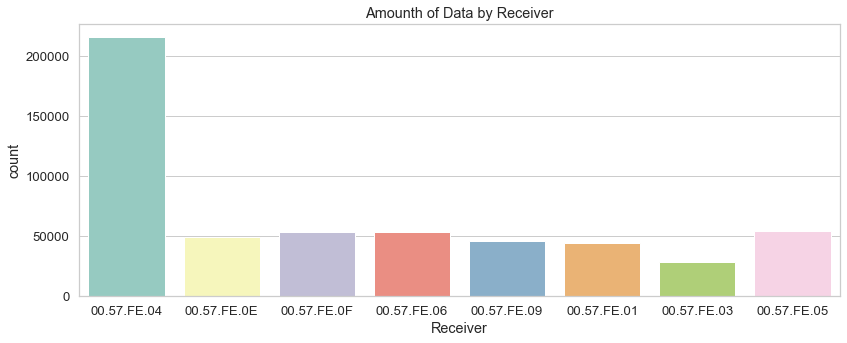

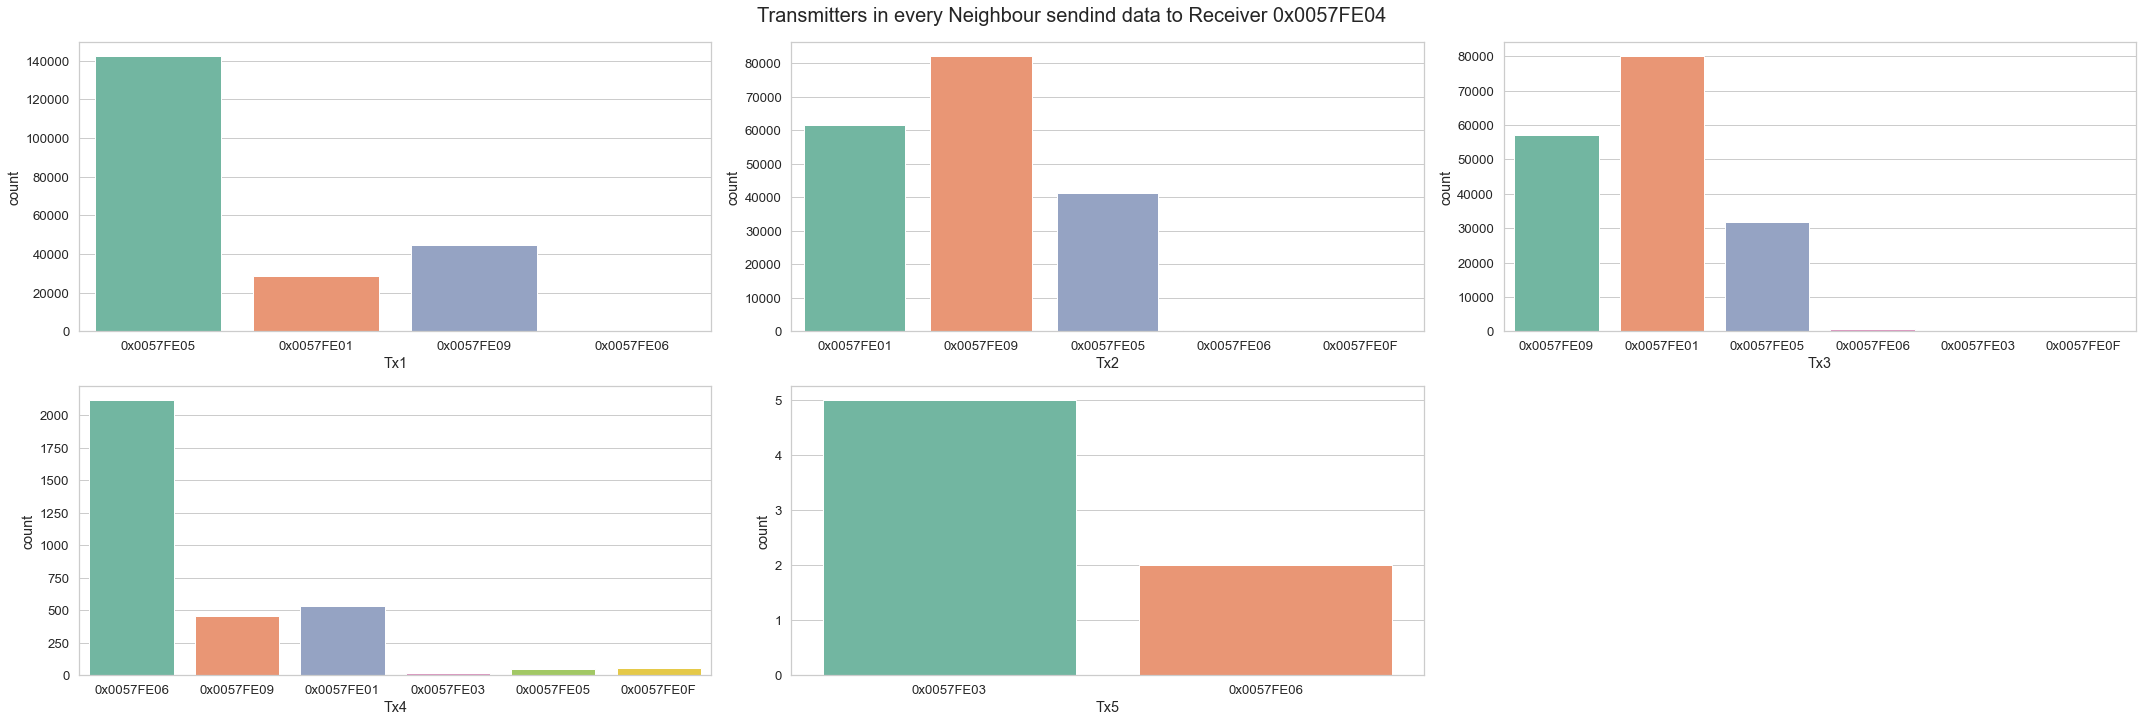

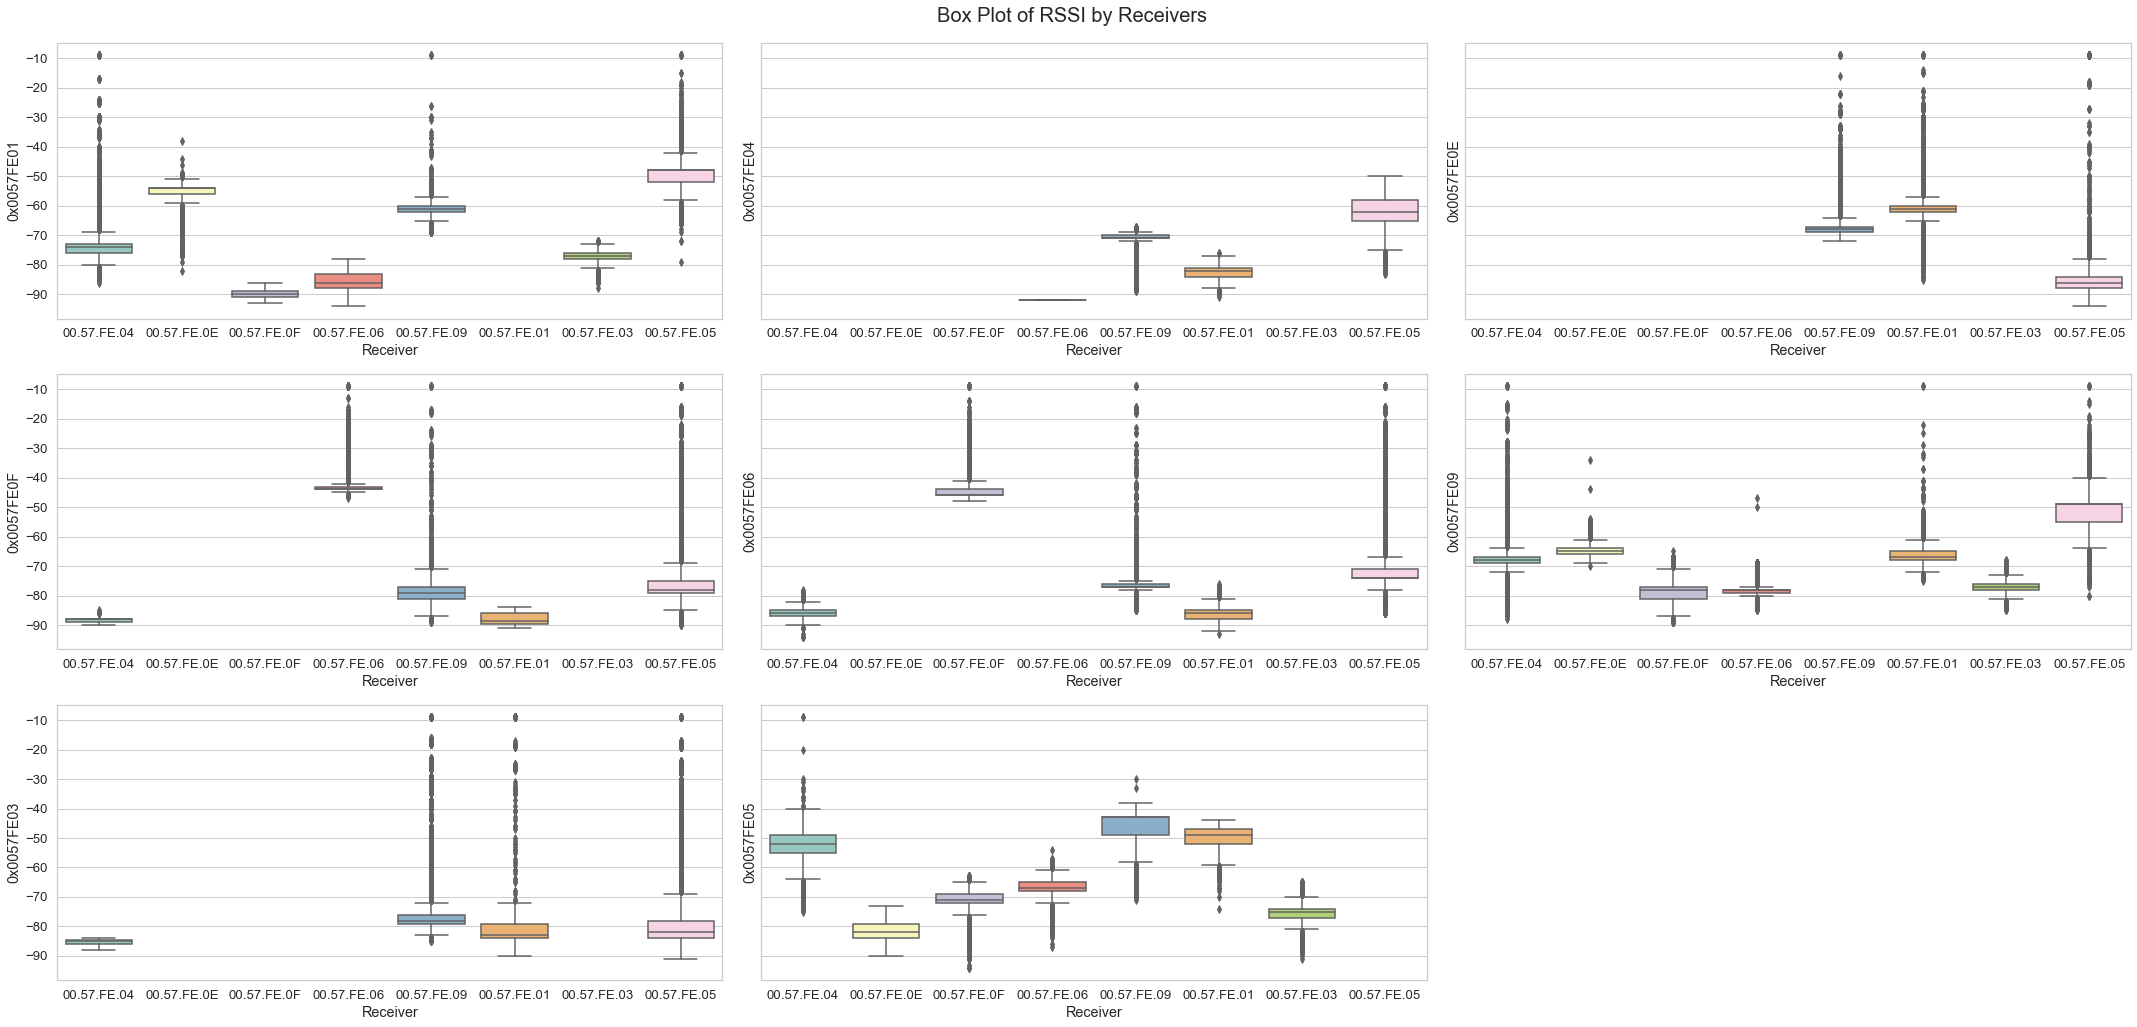

In [338]:
plot_count_transmitters(dff, subset)

fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=(30,14), sharey=True)
fig.delaxes(axarr[2,2])
plt.suptitle('Box Plot of RSSI by Receivers', x=0.5, y=1.02, fontsize=20)
sns.boxplot(x='Receiver',y=dff[dff.columns[6]],data=dff, ax=axarr[0,0], palette='Set3')
sns.boxplot(x='Receiver',y=dff[dff.columns[1]],data=dff, ax=axarr[0,1], palette='Set3')
sns.boxplot(x='Receiver',y=dff[dff.columns[2]],data=dff, ax=axarr[0,2], palette='Set3')
sns.boxplot(x='Receiver',y=dff[dff.columns[3]],data=dff, ax=axarr[1,0], palette='Set3')
sns.boxplot(x='Receiver',y=dff[dff.columns[4]],data=dff, ax=axarr[1,1], palette='Set3')
sns.boxplot(x='Receiver',y=dff[dff.columns[5]],data=dff, ax=axarr[1,2], palette='Set3')
sns.boxplot(x='Receiver',y=dff[dff.columns[7]],data=dff, ax=axarr[2,0], palette='Set3')
sns.boxplot(x='Receiver',y=dff[dff.columns[8]],data=dff, ax=axarr[2,1], palette='Set3')
plt.yticks(np.arange(-10, -100, step=-10))
plt.tight_layout()

Next we can see the distribution of the RSSI of transmitter to every receiver. By the distributions we can conclude what Radios are closer or further than the others and compare with the expected

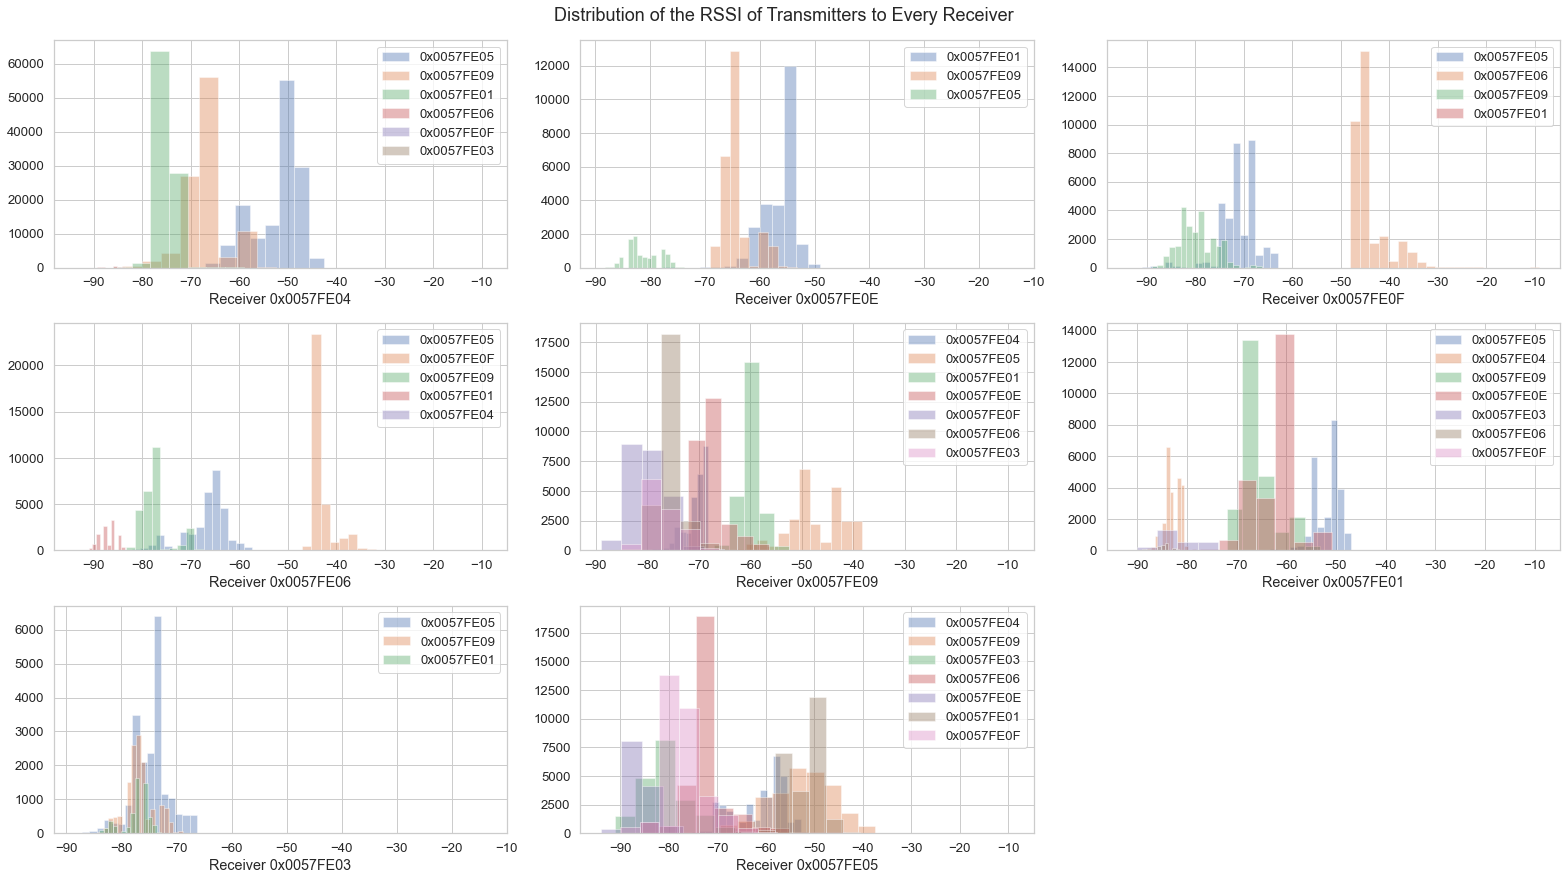

In [379]:
fig, axes = plt.subplots(3,3, figsize=(22,12), sharex=False)
fig.suptitle('Distribution of the RSSI of Transmitters to Every Receiver', x=0.5, y=1.02, fontsize=18)
fig.delaxes(axes[2,2])
for rec, ax in zip(range(len(RECEIVERS)), axes.flat):
    dist_transmissions(df_powers, rec, RECEIVERS, ax)
    
# this is to create a boxplot by date of every receiver
#for ii in dff.columns[1:8]:
#    boxplot_PowerMod_date(dff, Tx=ii)
#    plt.tight_layout()
    
#plot_by_date(dff, by='day')

# Get correlation matrix
#correlation = dff.corr(method='pearson')
#fig, ax1 = plt.subplots(1,1, figsize=(18,12))
#ax1.set_title('Correlation Matrix for all RSSI data')
#sns.heatmap(correlation, annot=True, cmap='Set2',ax=ax1)
#plt.tight_layout()

# If needed the Reciprocal
#plot_reciprocal_RSSI(dff)

## **Ouliers detection**

*Observation which deviates so much from other observations as to arouse suspicion it was generated by a different mechanism*<br>
*--- Hawkings (1980)*

Outliers are extreme values that deviate from other observations on data , they may indicate a variability in a measurement, experimental errors or a novelty. In other words, an **outlier is an observation that diverges from an overall pattern on a sample.** Outliers can be of two kinds: univariate and multivariate. Univariate outliers can be found when looking at a distribution of values in a single feature space. Multivariate outliers can be found in a n-dimensional space (of n-features). Looking at distributions in n-dimensional spaces can be very difficult for the human brain, that is why we need to train a model to do it for us.

Outliers can also come in different flavours, depending on the environment: point outliers, contextual outliers, or collective outliers. Point outliers are single data points that lay far from the rest of the distribution. Contextual outliers can be noise in data, such as punctuation symbols when realizing text analysis or background noise signal when doing speech recognition. Collective outliers can be subsets of novelties in data such as a signal that may indicate the discovery of new phenomena.

In the process of producing, collecting, processing and analyzing data, outliers can come from many sources and hide in many dimensions. Those that are not a product of an error are called **novelties**. Detecting outliers is of major importance for almost any quantitative discipline (ie: Physics, Economy, Finance, Machine Learning, Cyber Security). In machine learning and in any quantitative discipline the quality of data is as important as the quality of a prediction or classification model.

### Outliers on this Dataset
Considering that the data follows Gaussian-like distribution. If we know that the distribution of values in the sample is Gaussian or Gaussian-like, we can use the standard deviation of the sample as a cut-off for identifying outliers. The Gaussian distribution has the property that the standard deviation from the mean can be used to reliably summarize the percentage of values in the sample.

So, if the mean is 28.2 and the standard deviation is 6.5 for module 34.B2.9F.A9, then all data in the sample between 34.7 and 21.7 will account for about 68% of the data sample. We can cover more of the data sample if we expand the range as follows: 1 Standard Deviation from the Mean: 68% ;2 Standard Deviations from the Mean: 95%; 3 Standard Deviations from the Mean: 99.7, 3.5 STD from Mean 99.9%.

A value that falls outside of 3 standard deviations is part of the distribution, but it is an unlikely or rare event at approximately 1 in 370 samples. Three standard deviations from the mean is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution. For smaller samples of data, perhaps a value of 2 standard deviations (95%) can be used, and for larger samples, perhaps a value of 4 standard deviations (99.9%) can be used.

*Given mu and sigma, a simple way to identify outliers is to compute a z-score for every xi, which is defined as the number of standard deviations away xi is from the mean […] Data values that have a z-score sigma greater than a threshold, for example, of three, are declared to be outliers.*

Not all data is normal or normal enough to treat it as being drawn from a Gaussian distribution. A good statistic for summarizing a non-Gaussian distribution sample of data is the Interquartile Range, or IQR for short. The IQR can be used to identify outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. The common value for the factor k is the value 1.5. A factor k of 3 or more can be used to identify values that are extreme outliers or “far outs” when described in the context of box and whisker plots. On a box and whisker plot, these limits are drawn as fences on the whiskers (or the lines) that are drawn from the box. Values that fall outside of these values are drawn as dots. We can calculate the percentiles of a dataset using the `percentile()` NumPy function that takes the dataset and specification of the desired percentile. The IQR can then be calculated as the difference between the 75th and 25th percentiles.

This methods aren't very accurate, cause they don't discriminate between outliers and novelties, in order to do so is needed a better anomaly detection method.

In [7]:
df2 = df
df_outliers, df2 = get_outliers(df2, Modules, std_times=3, verbose=False, remove=True)

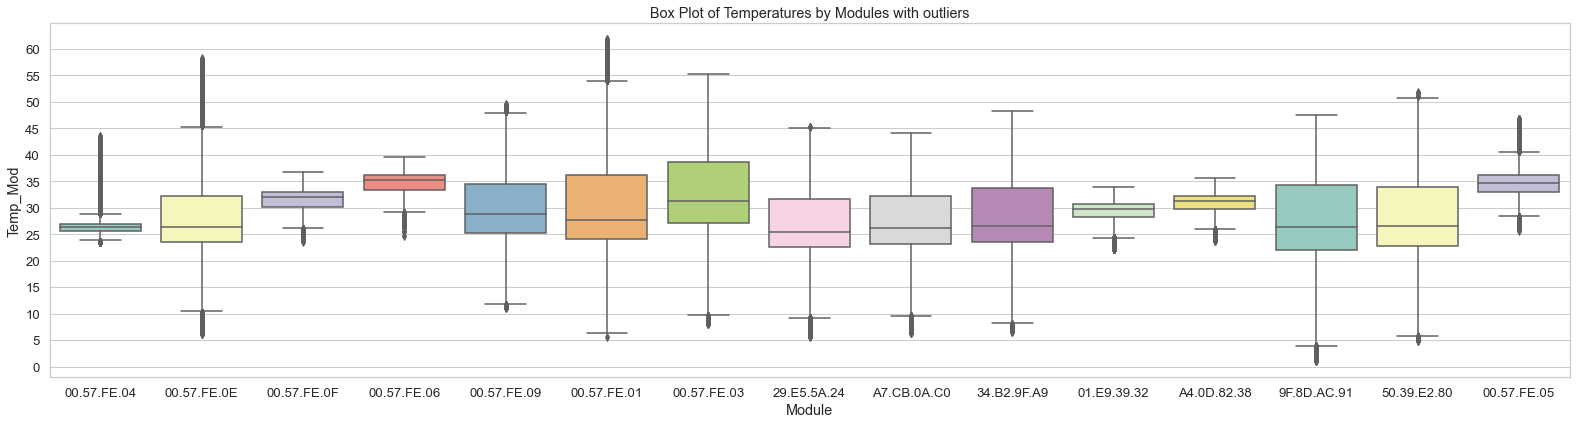

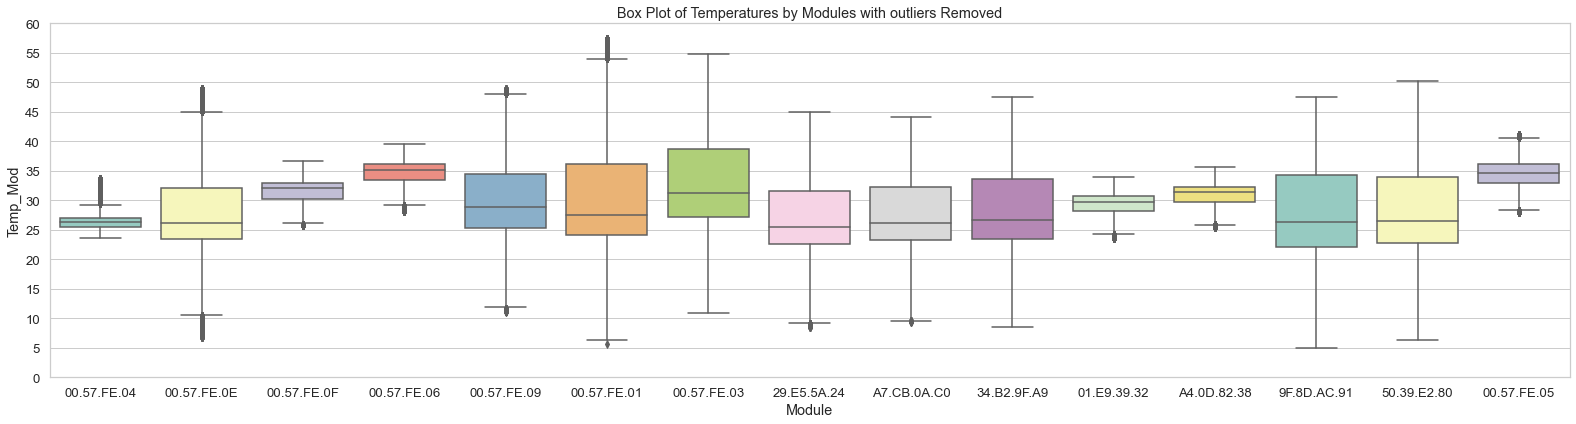

In [8]:
plt.figure(figsize=(22,6))
plt.title('Box Plot of Temperatures by Modules with outliers')
sns.boxplot(x='Module',y='Temp_Mod',data=df, palette='Set3')
plt.yticks(ticks=np.arange(0,65,step=5))
#plt.xticks(rotation=60)
plt.tight_layout()
plt.figure(figsize=(22,6))
plt.title('Box Plot of Temperatures by Modules with outliers Removed')
sns.boxplot(x='Module',y='Temp_Mod',data=df2, palette='Set3', fliersize=5)
plt.yticks(ticks=np.arange(0,65,step=5))
#plt.xticks(rotation=60)
plt.tight_layout()

We can see that a considerably amounth of outliers was removed, now, there is no ensurance that all this data were in fact outliers. Therefor, a more accurate method of detection of outliers must be implemented. If we make a `pd.describe()` we can see the amounth of possible outliers by module

In [16]:
df_outliers.describe().loc[['count']]

00.57.FE.04  00.57.FE.0E  00.57.FE.0F  00.57.FE.06  00.57.FE.09  \
count      65532.0       3288.0       1796.0       2014.0         19.0   

       00.57.FE.01  00.57.FE.05  00.57.FE.03  29.E5.5A.24  A7.CB.0A.C0  \
count        931.0       3306.0        233.0        240.0        167.0   

       34.B2.9F.A9  01.E9.39.32  A4.0D.82.38  9F.8D.AC.91  50.39.E2.80  
count         53.0        742.0        622.0        194.0         48.0

In [20]:
# Locate entry with some outliers
slice_of_data= df[df['Module']== '34.B2.9F.A9']
slice_of_data = slice_of_data.dropna(axis=1, how='all')
slice_of_data[slice_of_data['Temp_Mod']==df_outliers['34.B2.9F.A9'][10]]

Timestamp       Module           Type  Temp_Mod   VBus  \
6031249 2019-07-07 05:58:44  34.B2.9F.A9  P-Solar Panel       7.9  3.266   
6031250 2019-07-07 06:03:57  34.B2.9F.A9  P-Solar Panel       7.9  3.254   
6031290 2019-07-07 11:08:56  34.B2.9F.A9  P-Solar Panel       7.9  3.236   

         V_MPPT  V_Panel  
6031249   3.268    0.000  
6031250   3.259    0.000  
6031290   3.237   15.745

Above is an example of possible outliers detected in the original dataset. The temperature of 7.9 degrees is considered an outlier in module 34.B2.9F.A9, but we can see that in 2 cases this temperature correspond to a Voltage Panel of 0 Volts, meaning there was no Sun, also, the timestamp indicates that it was early in the morning and all values are in the same day, therefor, there is a possibility that this is a valid value, and also, all the points in the vecinity are close to this value so the possibility is that it was just a very cold day. <br>
This are **collective outliers**. The 3rd example does looks suspicious, since the Panel was generating good voltage (15 Volts) and it was almost noon. But, wee saw that there is some correlation between this features (V_Panel and Temperature). This is why is needed a stronger method for outlier detection.

A safe bet also is to use wisdom of the crowds by using multiple ensemble methods. We can then choose to combine them through majority vote, or union or intersection of the individual algorithms’ verdicts.

### **Trying other methods for anomaly detection**

Conventional statistical methods are generally more interpretable and sometimes more useful than machine learning-based methods, depending on the specified problem. Some are Holt-Winters(Triple Exponential Smoothing), ARIMA (Auto-Regressive Integrated Moving Average) and Histogram-Based Outlier Detection (HBOS).

Machine Learning methods can model more complex data and hence able to detect more complex anomalies than conventional statistical methods. Thety can be Supervised (e.g. Decision Tree, SVM, LSTM Forecasting), Unsupervised (e.g. K-Means, Hierarchical Clustering, DBSCAN, Isolation Forest), Self-Supervised (e.g. LSTM Autoencoder) and the data represented in Points, Rolling Window (or trajectory matrix) or Time Series Features (transformations, decompositions and statistical measurements).

So i'm going to try out some Machine leatning methods using and use the **Wisdom of the crowds** thinking. Also, since i don't know where are the nomalies, this is a problem of unsupervised learning, so i will consider that there are a small fraction of anomalies and the majority of the data is correct.

### Preparing the data

**Now, for every data we have a timestamp, Temperture of the modules, voltage and date features. I'm going to use all those features and the specific ones per module to make an anomaly detection or novelty detection. The detections will be made module by module, not using the entire dataset at once.**

In [8]:
slices = separete_modules(df, dictionary=Modules)

In [9]:
# here is how it looks the list
slices[0].head()

Timestamp       Module             Type  Temp_Mod   VBus  hour  \
0 2017-10-01 00:00:05  00.57.FE.04  Net-Coordinator      25.3  4.736     0   
1 2017-10-01 00:00:42  00.57.FE.04  Net-Coordinator      25.3  4.743     0   
2 2017-10-01 00:01:13  00.57.FE.04  Net-Coordinator      25.3  4.743     0   
3 2017-10-01 00:01:42  00.57.FE.04  Net-Coordinator      25.3  4.743     0   
4 2017-10-01 00:02:05  00.57.FE.04  Net-Coordinator      25.3  4.743     0   

   day  month  daylight  
0    1     10         0  
1    1     10         0  
2    1     10         0  
3    1     10         0  
4    1     10         0

## K-Means and PCA for collective anomalies

We group together the usual combination of features. The points that are far from the cluster are points with unusual combination of features. We consider those points as anomalies.<br>
**Results:**<br>
Tried with 20 clusters the firts time and the method takes to long to separate the data and then to get the distance from every point (more than 2 hours and only with module 04).<br>
The algorithm recognizes anomalies in the center values, but is not good for anomalies in the extremes.

**Take useful feature and standardize them**

## Gaussian for unordered collective anomalies

First i will do it for a single feature. The outliers fraction is still a small number.<br>
**Results**<br>
The algorithm recognizes anomalies in the higher values but takes very few from small ones. In contrast with K-Means the algorithm is very fast.

In [97]:
outliers_fraction = 0.02

In [98]:
# apply ellipticEnvelope (gaussian distribution) at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = slices[1]['Temp_Mod'].values.reshape(-1,1)
envelope.fit(X_train)

EllipticEnvelope(assume_centered=False, contamination=0.02, random_state=None,
                 store_precision=True, support_fraction=None)

In [103]:
slices[1]['deviation'] = envelope.decision_function(X_train)
slices[1]['anomaly_Gaussian'] = envelope.predict(X_train)
slices[1].head()

Timestamp       Module           Type  Temp_Mod   VBus  hour  day  \
0 2017-10-01 00:00:34  00.57.FE.0E  Radio-2.4 GHz      20.1  3.296     0    1   
1 2017-10-01 00:02:34  00.57.FE.0E  Radio-2.4 GHz      19.9  3.296     0    1   
2 2017-10-01 00:04:30  00.57.FE.0E  Radio-2.4 GHz      19.9  3.296     0    1   
3 2017-10-01 00:06:30  00.57.FE.0E  Radio-2.4 GHz      19.9  3.296     0    1   
4 2017-10-01 00:08:30  00.57.FE.0E  Radio-2.4 GHz      20.1  3.296     0    1   

   month  daylight  cluster  principal_feature1  principal_feature2  \
0     10         0        5              1.3952             -0.2833   
1     10         0        5              1.4042             -0.2839   
2     10         0        5              1.4042             -0.2839   
3     10         0        5              1.4042             -0.2839   
4     10         0        5              1.3952             -0.2833   

   anomaly_Kmeans  deviation  anomaly_Gaussian  
0               0    12.4298                 1  
1               0    12.3309                 1  
2               0    12.3309                 1  
3               0    12.3309                 1  
4               0    12.4298                 1

In [107]:
# anomalies marked as -1
anomaly = slices[1].loc[slices[1]['anomaly_Gaussian'] == -1, ['Timestamp', 'Temp_Mod']] #anomaly

In [111]:
from matplotlib import gridspec

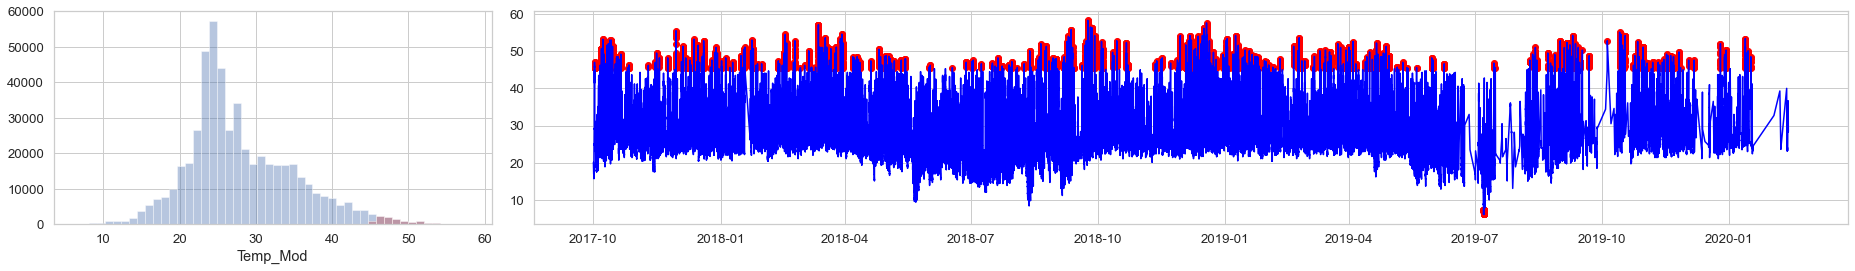

In [120]:
fig = plt.figure(figsize=(26,4))
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 3])

ax0 = fig.add_subplot(spec[0])
sns.distplot(a=slices[1]['Temp_Mod'], kde=False, ax=ax0)
sns.distplot(a=anomaly['Temp_Mod'], kde=False, color='r', ax=ax0)
ax1 = fig.add_subplot(spec[1])
ax1.plot(slices[1]['Timestamp'], slices[1]['Temp_Mod'], color='blue')
ax1.scatter(anomaly['Timestamp'],anomaly['Temp_Mod'], color='red')
plt.tight_layout()

**The elliptical envelope method has a good detection of extreme values.**

After trying Gaussian method, let's try three other different algorithms for anomaly detection.

## Isolation Forest for collective anomalies (unordered).

Isolation forest is a machine learning algorithm for anomaly detection. It's an unsupervised learning algorithm that identifies anomaly by isolating outliers in the data.

Isolation Forest is based on the Decision Tree algorithm. It isolates the outliers by randomly selecting a feature from the given set of features and then randomly selecting a split value between the max and min values of that feature. This random partitioning of features will produce shorter paths in trees for the anomalous data points, thus distinguishing them from the rest of the data.

In general the first step to anomaly detection is to construct a profile of what's "normal", and then report anything that cannot be considered normal as anomalous. However, the isolation forest algorithm does not work on this principle; it does not first define "normal" behavior, and it does not calculate point-based distances. The Isolation Forest algorithm is based on the principle that anomalies are observations that are few and different, which should make them easier to identify. Isolation Forest uses an ensemble of Isolation Trees for the given data points to isolate anomalies.

Isolation Forest recursively generates partitions on the dataset by randomly selecting a feature and then randomly selecting a split value for the feature. Presumably the anomalies need fewer random partitions to be isolated compared to "normal" points in the dataset, so the anomalies will be the points which have a smaller path length in the tree, path length being the number of edges traversed from the root node.

*Using Isolation Forest, we can not only detect anomalies faster but we also require less memory compared to other algorithms.*

Let's first split the dataset, we are not going to use all the data, there is no need to

## LSTM with multivariate features for  sequential anomalies (ordered)

The basic idea of anomaly detection with LSTM neural network is this: the system looks at the previous values over hours or days and predicts the behavior for the next minute. If the actual value a minute later is within, let’s say, one standard deviation, then there is no problem. If it is more it is an anomaly.

LSTM is used to look for anomalies in a period of time, but not in the entire dataset, although it can be runned over different parts of the dataset. These types of networks excel at finding complex relationships in multivariate time series data. 

The system looks to the trends of the Temperature, Voltage, day, hour, daylight, month and 2 more features in the case of sensors. We have acces to 2 years of data, which is a lot of data. Sicne LSTM looks at previous values in timesteps, i'll chose four different tensor configurations: 16, 32, 64, and 128-time steps with non overlapping windows and try different network configurations.

As said before, i have 26 months of samples, but to predict, let's say, the next 2 days i don't need to look at the past 2 years, instead i will start with 14 days in the past, then 10, then 7 days. The dataset will be divided into training and testing sets, the testing set is for the prediction. First i will take all the data to forecast the future and see results, then i will take only a part of the data and see how well it performs. The training set is divided into batches of a specific size (let's say 50), so the training set will have the sape of `[n_samples, timesteps, n_features]`. This means that i will take a number of timesteps in the past to predict one value in the future. Even though this is a multiple features problem, and the output can be `n_features` size, this time i just want to predict the behaviour of one specific feature.



##### **Splitting and scaling the data**

I want to predict what will be the behaviour 2 days in the future by looking at 14 days in the past. In  real time, meaning, if don't have the data of the future 2 days, i would only take the past 14 days, but since i have the data, and this a training of the model i will take the full 16 days. For Radio modules we have much more data, so the training will be better, therefor the model will have take this into consideration and make a tradeoff in acurracy and overfitting.<br> 

**Also, since the data doesn't have a clear frequency defined, we can resample the dataset to have a definded frequency using mean. The missing data must be filled.**

In [99]:
# Here taking only one module
slice_of_data = df[df['Module']== '00.57.FE.0E'].dropna(axis=1, how='all')
slice_of_data.set_index('Timestamp', inplace=True)

In [100]:
outliers_fraction = 0.01
final_date='2019-01-20 00:00:05'
split_date = '2018-11-01 00:00:05'
test_date = '2019-01-16 00:00:05'
resample_time = '5Min'

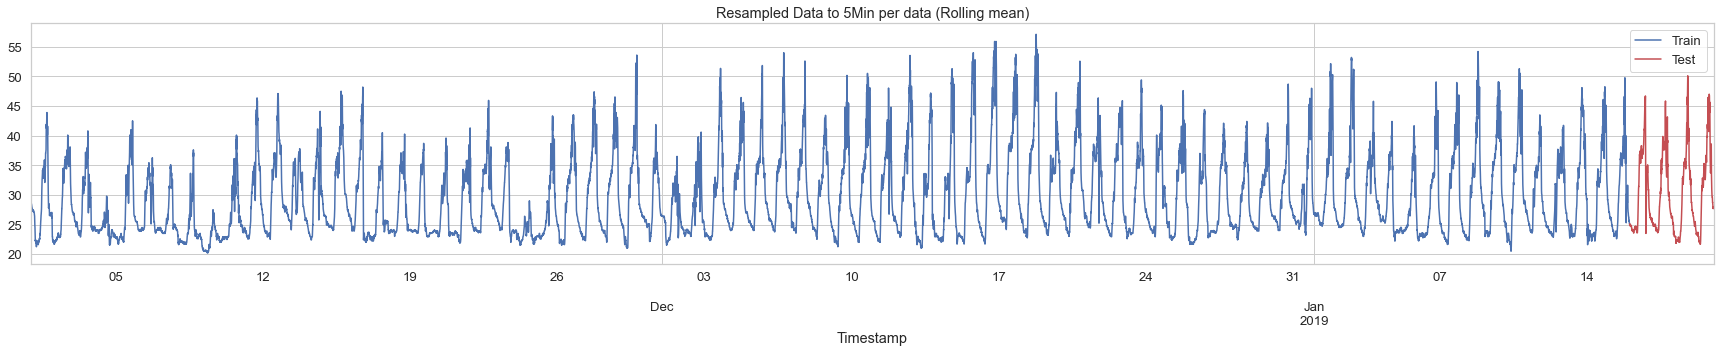

In [101]:
# Splitting by date, saving a part for testing
data, train_data, test_data, X_train, X_test, y_train, y_test, scaler = create_train_test(slice_of_data, final_date=final_date, split_date=split_date, test_date=test_date,
                                                                                          resample_time=resample_time, figsize=(24,5), scaler=MinMaxScaler())

##### **Create segments of data**

In [102]:
# How many timestamps in the past to make a single prediction
timesteps = 64
X_train_seg, y_train_seg = split_sequences(X_train, feature_index=0, n_steps=timesteps)
X_test_seg, y_test_seg = split_sequences(X_test, feature_index=0, n_steps=timesteps)
train_X, train_y = split_sequences_multivariate(X_train, n_steps=64)
test_X, test_y = split_sequences_multivariate(X_test, n_steps=64)

n_features, n_timesteps, n_samples  = X_train_seg.shape[-1], X_train_seg.shape[-2], X_train_seg.shape[0]
n_outputs_s, n_outputs_m = 1, train_X.shape[-1] 
n_predictions = 1
print('Number of Samples {} -> Number of timesteps {} -> Number of features {}'.format(n_samples, n_timesteps, n_features))

(21824, 64, 6) (21824,)
(1088, 64, 6) (1088,)
(21824, 64, 6) (21824, 6)
(1088, 64, 6) (1088, 6)
Number of Samples 21824 -> Number of timesteps 64 -> Number of features 6


#### **Create and fit LSTM model**

Since this is a regression problem, there is no accuracy

In [81]:
# define model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dense(128, activation='linear'))
#model.add(Dropout(0.2))
model.add(Dense(n_outputs_s, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
#model.summary()

In [82]:
# Hyper-parameters
BATCH_SIZE = 256
EPOCHS = 30
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='auto', verbose=1)]

In [83]:
# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model.fit(x=X_train_seg, y=y_train_seg, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    callbacks=callbacks_list, validation_split=0.1, verbose=1)
# convert the history.history dict to a pandas DataFrame:     
history_df = pd.DataFrame(history.history) 

Train on 19641 samples, validate on 2183 samples
Epoch 1/30
19641/19641 [==============================] - 54s 3ms/step - loss: 0.0101 - val_loss: 0.0035
Epoch 2/30
19641/19641 [==============================] - 58s 3ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 3/30
19641/19641 [==============================] - 63s 3ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 4/30
19641/19641 [==============================] - 54s 3ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 5/30
19641/19641 [==============================] - 55s 3ms/step - loss: 9.4836e-04 - val_loss: 0.0011
Epoch 6/30
19641/19641 [==============================] - 52s 3ms/step - loss: 7.3556e-04 - val_loss: 9.6289e-04
Epoch 7/30
19641/19641 [==============================] - 50s 3ms/step - loss: 6.2474e-04 - val_loss: 7.7400e-04
Epoch 8/30
19641/19641 [==============================] - 54s 3ms/step - loss: 5.3028e-04 - val_loss: 8.9576e-04
Epoch 9/30
19641/19641 [==============================] - 54s 3ms/step - loss: 6.47

##### **Save and evaluate model**

We can see some spikes much bigger than the prediction, this spikes can be considered as anomalies, since the temperature went too far beyond what was expected.

**Now we have to chose a threshold**. We can take the minimum value of the largest ones, or consider 1 or 2 standar deviations away as the threshold. We can take the mean absolute error from the training test and set a threshold using 3 standard deviations away, the compare the mean absolute error in testing with this threshold.

In [87]:
name= 'Model//model_LSTM_E' + str(EPOCHS) + '_BZ' + str(BATCH_SIZE) + '_D' + str(0) + '_Res_' + resample_time
serialize_model(model, history_df, name= name)
#model=load_model('Model//model_LSTM_E'+str(EPOCHS)+'_BZ'+str(BATCH_SIZE)+'_D'+str(0)+'_Res_'+resample_time)

Saved model to disk


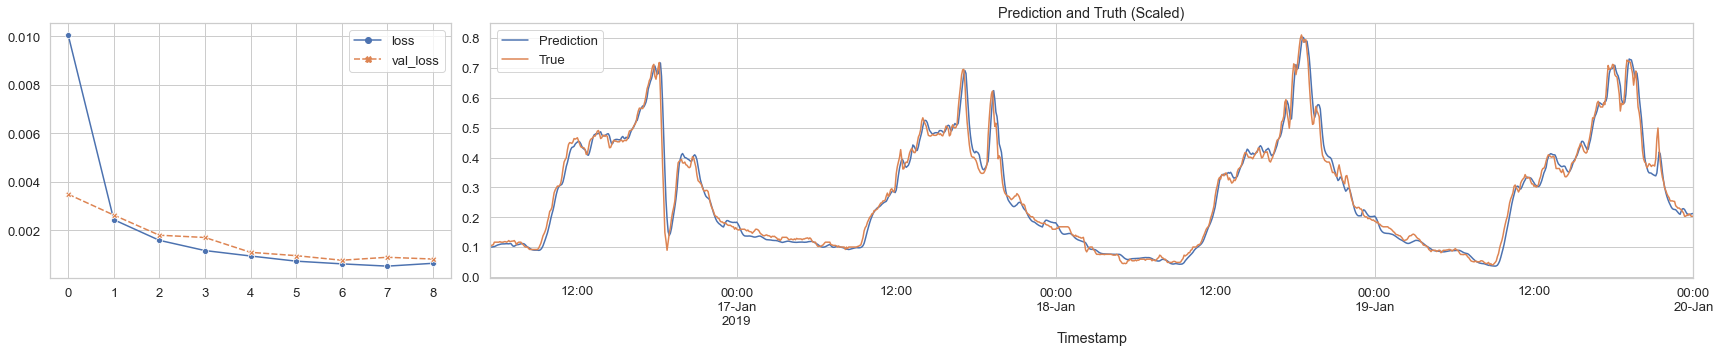

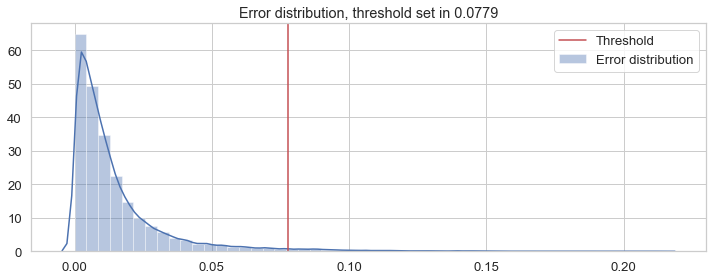

In [103]:
plot_model_results(model, history_df, X_test_seg, y_test_seg, index=test_data.index[64:])

# create the list of difference between prediction and test data
abs_err_train, threshold = get_abs_err(X_train_seg, y_train_seg, model, std=4, plot=True)
abs_err_test = get_abs_err(X_test_seg, y_test_seg, model, plot=False)

In [104]:
# run the other methods
data, anomaly_Iforest = isolation_forest(data, n_estimators=50, outliers_fraction=0.01, scaler=MinMaxScaler())
data, anomaly_svm = oneClass_SVM(data, nu=0.95, outliers_fraction=0.01, scaler=MinMaxScaler())
#LSTM
predictions_df, anomalies_LSTM = get_anomaly_and_pred(model, X_test_seg, y_test_seg, threshold, test_data)
data['anomaly_LSTM'] = anomalies_LSTM
data['anomaly_LSTM'] = data['anomaly_LSTM'].fillna(0) # Fill the rest with 0

print(anomaly_Iforest.describe().transpose())
print(anomaly_svm.describe().transpose())
print(data[data['anomaly_LSTM']==1][['Temp_Mod']].describe().transpose())

          count     mean      std    min   25%      50%   75%   max
Temp_Mod  229.0  41.1618  11.5816  22.75  28.0  46.3333  51.8  57.1
          count     mean      std   min      25%   50%      75%   max
Temp_Mod  218.0  33.3306  11.0862  21.7  25.4333  27.7  43.3375  57.1
          count     mean     std   min      25%     50%    75%      max
Temp_Mod   28.0  37.9119  5.7801  23.5  37.0625  38.925  41.45  45.8333


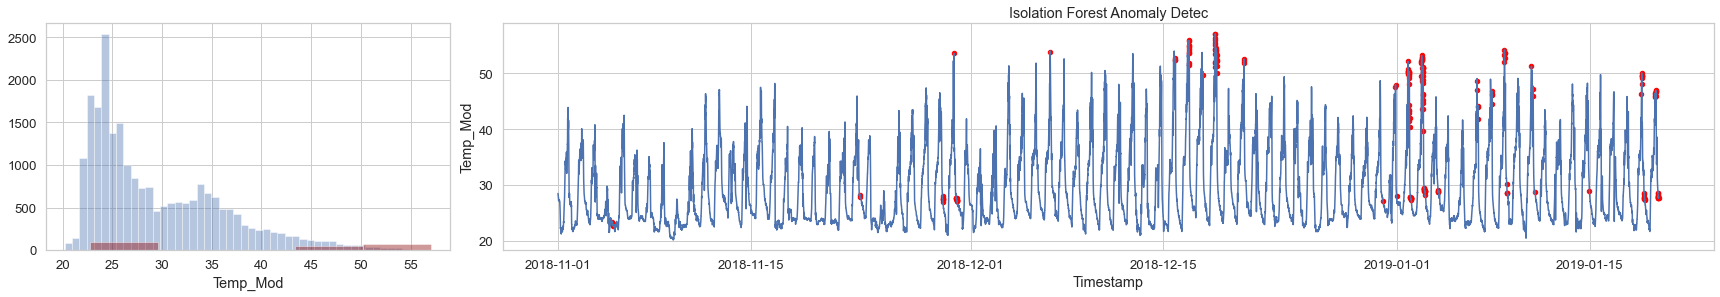

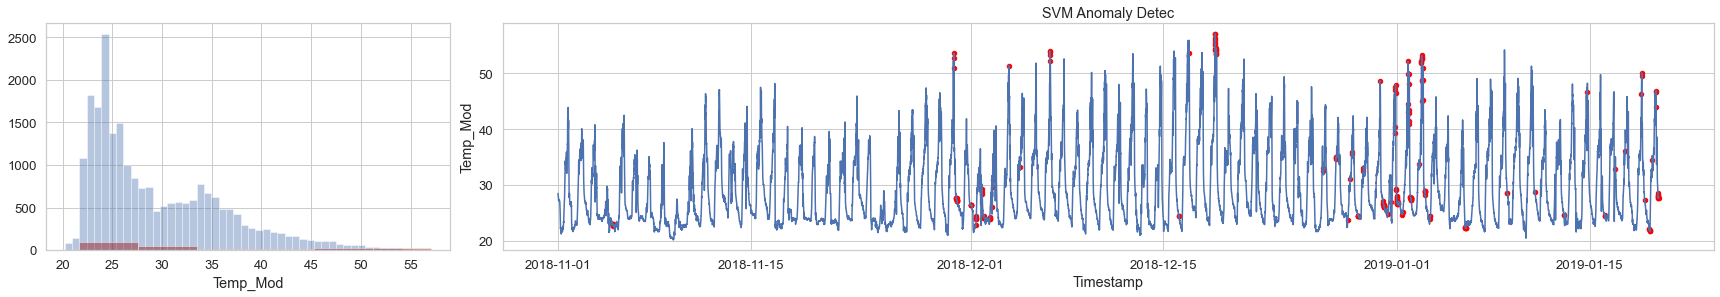

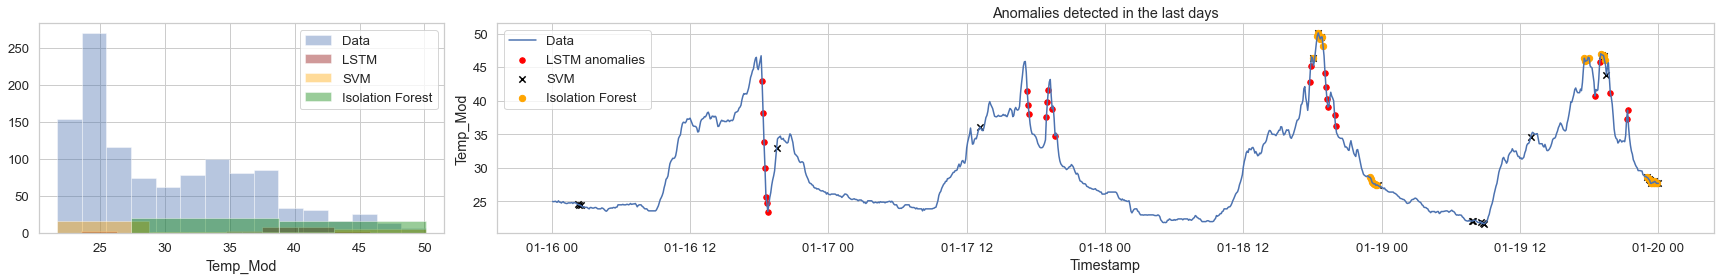

In [105]:
plot_anomalies_model(data, test_date, anomaly_Iforest, select='others')
plt.title('Isolation Forest Anomaly Detec')
plot_anomalies_model(data, test_date, anomaly_svm, select='others')
plt.title('SVM Anomaly Detec')
#plot_anomalies_model(data, test_date, anomalies_LSTM, select='LSTM')
plot_anomalies_model(data, test_date, anomalies_LSTM, select='all', anomalies_svm=anomaly_svm, anomalies_forest=anomaly_Iforest)

Isolation Forest is much more faster finding anomalies than Gaussian and detects distributed anomalies. Didn't detected outliers with small values either. SVM gives a result similar to Isolation forest, but with more anomalies. Slighly better at finding anomalies with smaller values.<br>
After running the algorithms, we can see that is possible to apply the concept of wisdom of the crowds since the algorithms have some results in common.

- Still, this is vulnerable to false positives since we are doing unsupervised anomaly detection.

- Another possible solution is to forecast some values and then look for anomalies comparing the forecast with the actual values and some threshold. The same trained model can be used to forecast but we need to see how good is at forecasting and how many values in the future we can predict with some minimal precision.<br> The idea is to predict some values, check for anomalies comparing the error of prediction with a threshold, then take the next set of values and do the same, but instead of forecast in a forecasted value, do it with the real values.

- Other possible solution, maybe more accurate, is to create a supervised problem creating 2 classes, anomaly and normal (clustering techniques). Stablish all the data we know is correct as normal data and create some anomalies based on what whe think an anomaly would look like. Then we would have a classification problem, that can be solved either using LSTM, DNN or CNN+WSN.

- Another way to see the anomalies is converting the data to another domain, like frequency domain using Fourier Transform, or time-freq using Wavelets.

- Use another method of forecasting like ARIMA